In [1]:
#----------------------------------------
# Set random seed for reproducibility.

seed = 543
from numpy import random
random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import classes and functions.

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation, concatenate, Dropout


Using TensorFlow backend.


In [3]:
#----------------------------------------
# Load the Haberman Compressive Strength dataset.

dataset = np.loadtxt("Haberman-Survival-Data.txt", delimiter = ",")

type(dataset)

dataset.shape

which = lambda status: np.arange(len(status))[status]

index = which(dataset[:, 3] == 2)

dataset[index, 3] = 0

x_group = [[2], [0], [1]]

X = dataset[:, 0:3]
Y = dataset[:, 3]

np.unique(Y)

X.shape
Y.shape

X1 = dataset[:, x_group[0]]
X2 = dataset[:, x_group[1]]
X3 = dataset[:, x_group[2]]

X1.shape; X2.shape; X3.shape
Y.shape



(306,)

In [4]:
#----------------------------------------
# Standardize the input and output data.

X_sample_mean = np.mean(X, axis = 0)
np.round(X_sample_mean, 4)

X_sample_std = np.std(X, axis = 0, ddof = 1)
np.round(X_sample_std, 4)

X1_sample_mean = X_sample_mean[x_group[0]]
np.round(X1_sample_mean, 4)

X1_sample_std = X_sample_std[x_group[0]]
np.round(X1_sample_std, 4)

X2_sample_mean = X_sample_mean[x_group[1]]
np.round(X2_sample_mean, 4)

X2_sample_std = X_sample_std[x_group[1]]
np.round(X2_sample_std, 4)

X3_sample_mean = X_sample_mean[x_group[2]]
np.round(X3_sample_mean, 4)

X3_sample_std = X_sample_std[x_group[2]]
np.round(X3_sample_std, 4)

standardize = lambda x: (x - np.mean(x, axis = 0)) / np.std(x, axis = 0, ddof = 1)

X_train = standardize(X)

X1_train = X_train[:, x_group[0]]
X2_train = X_train[:, x_group[1]]
X3_train = X_train[:, x_group[2]]

np.round(np.mean(X1_train, axis = 0), 4)
np.round(np.std(X1_train, axis = 0, ddof = 1), 4)

np.round(np.mean(X2_train, axis = 0), 4)
np.round(np.std(X2_train, axis = 0, ddof = 1), 4)

np.round(np.mean(X3_train, axis = 0), 4)
np.round(np.std(X3_train, axis = 0, ddof = 1), 4)

Y_train = Y


In [5]:
# Define 10-fold cross validation test index sets.

fold_num = 10

L = len(X_train)

quotient = L // fold_num
remainder = L % fold_num

fold_length = np.array([quotient]*fold_num)
if remainder > 0:
    fold_length[0:remainder] = fold_length[0:remainder] + 1

index_begin = np.zeros(fold_num, dtype = int)
index_begin[0] = 0

for j in range(1, fold_num):
    index_begin[j] = index_begin[j-1] + fold_length[j-1]

index = np.random.choice(np.arange(L), size = L, replace = False)


In [6]:
# 10-fold cross validation

cv_bc = []
cv_acc = []

for k in range(fold_num):
    # Build the tree like nn model
    input_g1 = Input(shape = (1,))
    x1 = input_g1
    t1 = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x1)
    t1 = Dropout(rate = 0.1)(t1)
    #
    y11 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    y12 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    #
    input_g2 = Input(shape = (1,))
    x2 = concatenate([y11, input_g2], axis = 1)  # column bind
    t2 = Dense(units = 4, kernel_initializer = "uniform", activation = "relu")(x2)
    t2 = Dropout(rate = 0.1)(t2)
    #
    y21 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t2)
    y22 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t2)
    #
    input_g3 = Input(shape = (1,))
    x3 = concatenate([y21, input_g3], axis = 1)  # column bind
    t3 = Dense(units = 4, kernel_initializer = "uniform", activation = "relu")(x3)
    t3 = Dropout(rate = 0.1)(t3)
    #
    y31 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    y32 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    #
    x_final =  concatenate([y12, y22, y31, y32], axis = 1)  # column bind
    y_final = Dense(units = 5, kernel_initializer = "uniform", activation = "relu")(x_final)
    y_final = Dropout(rate = 0.1)(y_final)
    y_final = Dense(units = 1, kernel_initializer = "uniform", activation = "sigmoid")(y_final)
    response = y_final
    #
    model = Model(inputs = [input_g1, input_g2, input_g3], outputs = response)
    #
    #model.summary()
    # Compile the model.
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Select index sets.
    seq_index = range(index_begin[k], (index_begin[k] + fold_length[k]))
    test_index = index[seq_index]
    train_index = np.delete(index, seq_index)
    # Fit the model.
    history = model.fit([X1_train[train_index], X2_train[train_index], X3_train[train_index]]
                        , Y_train[train_index], validation_split = 0.2, epochs = 1000, batch_size = 40, verbose = 2)
    # Evaluate the model.
    scores = model.evaluate([X1_train[test_index], X2_train[test_index], X3_train[test_index]]
                            , Y_train[test_index], verbose = 0)
    print("%s: %.4f" % (model.metrics_names[0], scores[0]))
    print("%s: %.4f" % (model.metrics_names[1], scores[1]))
    cv_bc.append(scores[0])
    cv_acc.append(scores[1])


Train on 220 samples, validate on 55 samples
Epoch 1/1000
 - 1s - loss: 0.6926 - acc: 0.6909 - val_loss: 0.6914 - val_acc: 0.7818
Epoch 2/1000
 - 0s - loss: 0.6913 - acc: 0.7273 - val_loss: 0.6897 - val_acc: 0.7818
Epoch 3/1000
 - 0s - loss: 0.6899 - acc: 0.7273 - val_loss: 0.6880 - val_acc: 0.7818
Epoch 4/1000
 - 0s - loss: 0.6885 - acc: 0.7273 - val_loss: 0.6861 - val_acc: 0.7818
Epoch 5/1000
 - 0s - loss: 0.6870 - acc: 0.7273 - val_loss: 0.6842 - val_acc: 0.7818
Epoch 6/1000
 - 0s - loss: 0.6854 - acc: 0.7273 - val_loss: 0.6823 - val_acc: 0.7818
Epoch 7/1000
 - 0s - loss: 0.6838 - acc: 0.7273 - val_loss: 0.6802 - val_acc: 0.7818
Epoch 8/1000
 - 0s - loss: 0.6823 - acc: 0.7273 - val_loss: 0.6779 - val_acc: 0.7818
Epoch 9/1000
 - 0s - loss: 0.6804 - acc: 0.7273 - val_loss: 0.6757 - val_acc: 0.7818
Epoch 10/1000
 - 0s - loss: 0.6785 - acc: 0.7273 - val_loss: 0.6732 - val_acc: 0.7818
Epoch 11/1000
 - 0s - loss: 0.6763 - acc: 0.7273 - val_loss: 0.6705 - val_acc: 0.7818
Epoch 12/1000
 - 0

Epoch 96/1000
 - 0s - loss: 0.5621 - acc: 0.7273 - val_loss: 0.4768 - val_acc: 0.7818
Epoch 97/1000
 - 0s - loss: 0.5716 - acc: 0.7273 - val_loss: 0.4767 - val_acc: 0.7818
Epoch 98/1000
 - 0s - loss: 0.5508 - acc: 0.7273 - val_loss: 0.4766 - val_acc: 0.7818
Epoch 99/1000
 - 0s - loss: 0.5570 - acc: 0.7273 - val_loss: 0.4757 - val_acc: 0.7818
Epoch 100/1000
 - 0s - loss: 0.5683 - acc: 0.7273 - val_loss: 0.4751 - val_acc: 0.7818
Epoch 101/1000
 - 0s - loss: 0.5671 - acc: 0.7273 - val_loss: 0.4747 - val_acc: 0.7818
Epoch 102/1000
 - 0s - loss: 0.5683 - acc: 0.7273 - val_loss: 0.4743 - val_acc: 0.7818
Epoch 103/1000
 - 0s - loss: 0.5562 - acc: 0.7273 - val_loss: 0.4748 - val_acc: 0.7818
Epoch 104/1000
 - 0s - loss: 0.5594 - acc: 0.7273 - val_loss: 0.4738 - val_acc: 0.7818
Epoch 105/1000
 - 0s - loss: 0.5435 - acc: 0.7273 - val_loss: 0.4733 - val_acc: 0.7818
Epoch 106/1000
 - 0s - loss: 0.5482 - acc: 0.7273 - val_loss: 0.4724 - val_acc: 0.7818
Epoch 107/1000
 - 0s - loss: 0.5537 - acc: 0.72

Epoch 191/1000
 - 0s - loss: 0.5462 - acc: 0.7273 - val_loss: 0.4425 - val_acc: 0.7818
Epoch 192/1000
 - 0s - loss: 0.5544 - acc: 0.7273 - val_loss: 0.4417 - val_acc: 0.7818
Epoch 193/1000
 - 0s - loss: 0.5517 - acc: 0.7273 - val_loss: 0.4407 - val_acc: 0.7818
Epoch 194/1000
 - 0s - loss: 0.5325 - acc: 0.7273 - val_loss: 0.4407 - val_acc: 0.7818
Epoch 195/1000
 - 0s - loss: 0.5439 - acc: 0.7273 - val_loss: 0.4397 - val_acc: 0.7818
Epoch 196/1000
 - 0s - loss: 0.5497 - acc: 0.7273 - val_loss: 0.4398 - val_acc: 0.7818
Epoch 197/1000
 - 0s - loss: 0.5613 - acc: 0.7273 - val_loss: 0.4400 - val_acc: 0.7818
Epoch 198/1000
 - 0s - loss: 0.5599 - acc: 0.7273 - val_loss: 0.4420 - val_acc: 0.7818
Epoch 199/1000
 - 0s - loss: 0.5384 - acc: 0.7273 - val_loss: 0.4416 - val_acc: 0.7818
Epoch 200/1000
 - 0s - loss: 0.5551 - acc: 0.7273 - val_loss: 0.4415 - val_acc: 0.7818
Epoch 201/1000
 - 0s - loss: 0.5610 - acc: 0.7273 - val_loss: 0.4405 - val_acc: 0.7818
Epoch 202/1000
 - 0s - loss: 0.5560 - acc: 

 - 0s - loss: 0.5487 - acc: 0.7273 - val_loss: 0.4372 - val_acc: 0.7818
Epoch 286/1000
 - 0s - loss: 0.5402 - acc: 0.7273 - val_loss: 0.4368 - val_acc: 0.7818
Epoch 287/1000
 - 0s - loss: 0.5455 - acc: 0.7273 - val_loss: 0.4369 - val_acc: 0.7818
Epoch 288/1000
 - 0s - loss: 0.5268 - acc: 0.7273 - val_loss: 0.4356 - val_acc: 0.7818
Epoch 289/1000
 - 0s - loss: 0.5476 - acc: 0.7273 - val_loss: 0.4350 - val_acc: 0.7818
Epoch 290/1000
 - 0s - loss: 0.5609 - acc: 0.7273 - val_loss: 0.4332 - val_acc: 0.7818
Epoch 291/1000
 - 0s - loss: 0.5496 - acc: 0.7273 - val_loss: 0.4340 - val_acc: 0.7818
Epoch 292/1000
 - 0s - loss: 0.5423 - acc: 0.7273 - val_loss: 0.4335 - val_acc: 0.7818
Epoch 293/1000
 - 0s - loss: 0.5350 - acc: 0.7273 - val_loss: 0.4340 - val_acc: 0.7818
Epoch 294/1000
 - 0s - loss: 0.5411 - acc: 0.7273 - val_loss: 0.4345 - val_acc: 0.7818
Epoch 295/1000
 - 0s - loss: 0.5447 - acc: 0.7273 - val_loss: 0.4335 - val_acc: 0.7818
Epoch 296/1000
 - 0s - loss: 0.5448 - acc: 0.7273 - val_lo

Epoch 380/1000
 - 0s - loss: 0.5348 - acc: 0.7273 - val_loss: 0.4382 - val_acc: 0.7818
Epoch 381/1000
 - 0s - loss: 0.5539 - acc: 0.7273 - val_loss: 0.4369 - val_acc: 0.7818
Epoch 382/1000
 - 0s - loss: 0.5473 - acc: 0.7273 - val_loss: 0.4367 - val_acc: 0.7818
Epoch 383/1000
 - 0s - loss: 0.5483 - acc: 0.7273 - val_loss: 0.4358 - val_acc: 0.7818
Epoch 384/1000
 - 0s - loss: 0.5555 - acc: 0.7273 - val_loss: 0.4353 - val_acc: 0.7818
Epoch 385/1000
 - 0s - loss: 0.5443 - acc: 0.7273 - val_loss: 0.4350 - val_acc: 0.7818
Epoch 386/1000
 - 0s - loss: 0.5546 - acc: 0.7273 - val_loss: 0.4355 - val_acc: 0.7818
Epoch 387/1000
 - 0s - loss: 0.5535 - acc: 0.7273 - val_loss: 0.4348 - val_acc: 0.7818
Epoch 388/1000
 - 0s - loss: 0.5401 - acc: 0.7273 - val_loss: 0.4349 - val_acc: 0.7818
Epoch 389/1000
 - 0s - loss: 0.5395 - acc: 0.7273 - val_loss: 0.4347 - val_acc: 0.7818
Epoch 390/1000
 - 0s - loss: 0.5390 - acc: 0.7273 - val_loss: 0.4337 - val_acc: 0.7818
Epoch 391/1000
 - 0s - loss: 0.5468 - acc: 

 - 0s - loss: 0.5394 - acc: 0.7273 - val_loss: 0.4353 - val_acc: 0.7818
Epoch 475/1000
 - 0s - loss: 0.5617 - acc: 0.7273 - val_loss: 0.4347 - val_acc: 0.7818
Epoch 476/1000
 - 0s - loss: 0.5415 - acc: 0.7273 - val_loss: 0.4354 - val_acc: 0.7818
Epoch 477/1000
 - 0s - loss: 0.5388 - acc: 0.7273 - val_loss: 0.4370 - val_acc: 0.7818
Epoch 478/1000
 - 0s - loss: 0.5396 - acc: 0.7273 - val_loss: 0.4367 - val_acc: 0.7818
Epoch 479/1000
 - 0s - loss: 0.5462 - acc: 0.7273 - val_loss: 0.4362 - val_acc: 0.7818
Epoch 480/1000
 - 0s - loss: 0.5452 - acc: 0.7273 - val_loss: 0.4363 - val_acc: 0.7818
Epoch 481/1000
 - 0s - loss: 0.5330 - acc: 0.7273 - val_loss: 0.4366 - val_acc: 0.7818
Epoch 482/1000
 - 0s - loss: 0.5357 - acc: 0.7273 - val_loss: 0.4378 - val_acc: 0.7818
Epoch 483/1000
 - 0s - loss: 0.5574 - acc: 0.7273 - val_loss: 0.4380 - val_acc: 0.7818
Epoch 484/1000
 - 0s - loss: 0.5491 - acc: 0.7273 - val_loss: 0.4386 - val_acc: 0.7818
Epoch 485/1000
 - 0s - loss: 0.5436 - acc: 0.7273 - val_lo

Epoch 569/1000
 - 0s - loss: 0.5472 - acc: 0.7273 - val_loss: 0.4342 - val_acc: 0.7818
Epoch 570/1000
 - 0s - loss: 0.5527 - acc: 0.7273 - val_loss: 0.4332 - val_acc: 0.7818
Epoch 571/1000
 - 0s - loss: 0.5493 - acc: 0.7273 - val_loss: 0.4315 - val_acc: 0.7818
Epoch 572/1000
 - 0s - loss: 0.5470 - acc: 0.7273 - val_loss: 0.4315 - val_acc: 0.7818
Epoch 573/1000
 - 0s - loss: 0.5450 - acc: 0.7273 - val_loss: 0.4317 - val_acc: 0.7818
Epoch 574/1000
 - 0s - loss: 0.5388 - acc: 0.7273 - val_loss: 0.4320 - val_acc: 0.7818
Epoch 575/1000
 - 0s - loss: 0.5529 - acc: 0.7273 - val_loss: 0.4312 - val_acc: 0.7818
Epoch 576/1000
 - 0s - loss: 0.5473 - acc: 0.7273 - val_loss: 0.4320 - val_acc: 0.7818
Epoch 577/1000
 - 0s - loss: 0.5566 - acc: 0.7273 - val_loss: 0.4335 - val_acc: 0.7818
Epoch 578/1000
 - 0s - loss: 0.5392 - acc: 0.7273 - val_loss: 0.4360 - val_acc: 0.7818
Epoch 579/1000
 - 0s - loss: 0.5430 - acc: 0.7273 - val_loss: 0.4368 - val_acc: 0.7818
Epoch 580/1000
 - 0s - loss: 0.5436 - acc: 

 - 0s - loss: 0.5407 - acc: 0.7273 - val_loss: 0.4347 - val_acc: 0.7818
Epoch 664/1000
 - 0s - loss: 0.5475 - acc: 0.7273 - val_loss: 0.4356 - val_acc: 0.7818
Epoch 665/1000
 - 0s - loss: 0.5537 - acc: 0.7273 - val_loss: 0.4359 - val_acc: 0.7818
Epoch 666/1000
 - 0s - loss: 0.5422 - acc: 0.7273 - val_loss: 0.4355 - val_acc: 0.7818
Epoch 667/1000
 - 0s - loss: 0.5518 - acc: 0.7273 - val_loss: 0.4366 - val_acc: 0.7818
Epoch 668/1000
 - 0s - loss: 0.5339 - acc: 0.7273 - val_loss: 0.4353 - val_acc: 0.7818
Epoch 669/1000
 - 0s - loss: 0.5615 - acc: 0.7273 - val_loss: 0.4354 - val_acc: 0.7818
Epoch 670/1000
 - 0s - loss: 0.5369 - acc: 0.7273 - val_loss: 0.4351 - val_acc: 0.7818
Epoch 671/1000
 - 0s - loss: 0.5385 - acc: 0.7273 - val_loss: 0.4347 - val_acc: 0.7818
Epoch 672/1000
 - 0s - loss: 0.5415 - acc: 0.7273 - val_loss: 0.4345 - val_acc: 0.7818
Epoch 673/1000
 - 0s - loss: 0.5370 - acc: 0.7273 - val_loss: 0.4343 - val_acc: 0.7818
Epoch 674/1000
 - 0s - loss: 0.5516 - acc: 0.7273 - val_lo

Epoch 758/1000
 - 0s - loss: 0.5529 - acc: 0.7273 - val_loss: 0.4318 - val_acc: 0.7818
Epoch 759/1000
 - 0s - loss: 0.5258 - acc: 0.7273 - val_loss: 0.4305 - val_acc: 0.7818
Epoch 760/1000
 - 0s - loss: 0.5478 - acc: 0.7273 - val_loss: 0.4301 - val_acc: 0.7818
Epoch 761/1000
 - 0s - loss: 0.5258 - acc: 0.7273 - val_loss: 0.4293 - val_acc: 0.7818
Epoch 762/1000
 - 0s - loss: 0.5611 - acc: 0.7273 - val_loss: 0.4296 - val_acc: 0.7818
Epoch 763/1000
 - 0s - loss: 0.5485 - acc: 0.7273 - val_loss: 0.4294 - val_acc: 0.7818
Epoch 764/1000
 - 0s - loss: 0.5523 - acc: 0.7273 - val_loss: 0.4313 - val_acc: 0.7818
Epoch 765/1000
 - 0s - loss: 0.5399 - acc: 0.7273 - val_loss: 0.4319 - val_acc: 0.7818
Epoch 766/1000
 - 0s - loss: 0.5378 - acc: 0.7273 - val_loss: 0.4326 - val_acc: 0.7818
Epoch 767/1000
 - 0s - loss: 0.5406 - acc: 0.7273 - val_loss: 0.4327 - val_acc: 0.7818
Epoch 768/1000
 - 0s - loss: 0.5466 - acc: 0.7273 - val_loss: 0.4326 - val_acc: 0.7818
Epoch 769/1000
 - 0s - loss: 0.5574 - acc: 

 - 0s - loss: 0.5406 - acc: 0.7273 - val_loss: 0.4345 - val_acc: 0.7818
Epoch 853/1000
 - 0s - loss: 0.5404 - acc: 0.7273 - val_loss: 0.4348 - val_acc: 0.7818
Epoch 854/1000
 - 0s - loss: 0.5283 - acc: 0.7273 - val_loss: 0.4342 - val_acc: 0.7818
Epoch 855/1000
 - 0s - loss: 0.5598 - acc: 0.7273 - val_loss: 0.4343 - val_acc: 0.7818
Epoch 856/1000
 - 0s - loss: 0.5249 - acc: 0.7273 - val_loss: 0.4348 - val_acc: 0.7818
Epoch 857/1000
 - 0s - loss: 0.5511 - acc: 0.7273 - val_loss: 0.4359 - val_acc: 0.7818
Epoch 858/1000
 - 0s - loss: 0.5442 - acc: 0.7273 - val_loss: 0.4364 - val_acc: 0.7818
Epoch 859/1000
 - 0s - loss: 0.5501 - acc: 0.7273 - val_loss: 0.4367 - val_acc: 0.7818
Epoch 860/1000
 - 0s - loss: 0.5392 - acc: 0.7273 - val_loss: 0.4359 - val_acc: 0.7818
Epoch 861/1000
 - 0s - loss: 0.5558 - acc: 0.7273 - val_loss: 0.4362 - val_acc: 0.7818
Epoch 862/1000
 - 0s - loss: 0.5545 - acc: 0.7273 - val_loss: 0.4358 - val_acc: 0.7818
Epoch 863/1000
 - 0s - loss: 0.5409 - acc: 0.7273 - val_lo

Epoch 947/1000
 - 0s - loss: 0.5482 - acc: 0.7273 - val_loss: 0.4323 - val_acc: 0.7818
Epoch 948/1000
 - 0s - loss: 0.5511 - acc: 0.7273 - val_loss: 0.4321 - val_acc: 0.7818
Epoch 949/1000
 - 0s - loss: 0.5517 - acc: 0.7273 - val_loss: 0.4329 - val_acc: 0.7818
Epoch 950/1000
 - 0s - loss: 0.5287 - acc: 0.7273 - val_loss: 0.4320 - val_acc: 0.7818
Epoch 951/1000
 - 0s - loss: 0.5400 - acc: 0.7273 - val_loss: 0.4324 - val_acc: 0.7818
Epoch 952/1000
 - 0s - loss: 0.5426 - acc: 0.7273 - val_loss: 0.4326 - val_acc: 0.7818
Epoch 953/1000
 - 0s - loss: 0.5398 - acc: 0.7273 - val_loss: 0.4329 - val_acc: 0.7818
Epoch 954/1000
 - 0s - loss: 0.5543 - acc: 0.7273 - val_loss: 0.4329 - val_acc: 0.7818
Epoch 955/1000
 - 0s - loss: 0.5493 - acc: 0.7273 - val_loss: 0.4339 - val_acc: 0.7818
Epoch 956/1000
 - 0s - loss: 0.5688 - acc: 0.7273 - val_loss: 0.4345 - val_acc: 0.7818
Epoch 957/1000
 - 0s - loss: 0.5549 - acc: 0.7273 - val_loss: 0.4363 - val_acc: 0.7818
Epoch 958/1000
 - 0s - loss: 0.5530 - acc: 

Epoch 41/1000
 - 0s - loss: 0.5985 - acc: 0.7273 - val_loss: 0.5500 - val_acc: 0.7818
Epoch 42/1000
 - 0s - loss: 0.5909 - acc: 0.7273 - val_loss: 0.5469 - val_acc: 0.7818
Epoch 43/1000
 - 0s - loss: 0.5920 - acc: 0.7273 - val_loss: 0.5431 - val_acc: 0.7818
Epoch 44/1000
 - 0s - loss: 0.5849 - acc: 0.7273 - val_loss: 0.5404 - val_acc: 0.7818
Epoch 45/1000
 - 0s - loss: 0.5803 - acc: 0.7273 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 46/1000
 - 0s - loss: 0.5949 - acc: 0.7273 - val_loss: 0.5346 - val_acc: 0.7818
Epoch 47/1000
 - 0s - loss: 0.5967 - acc: 0.7273 - val_loss: 0.5322 - val_acc: 0.7818
Epoch 48/1000
 - 0s - loss: 0.5993 - acc: 0.7273 - val_loss: 0.5318 - val_acc: 0.7818
Epoch 49/1000
 - 0s - loss: 0.5953 - acc: 0.7273 - val_loss: 0.5311 - val_acc: 0.7818
Epoch 50/1000
 - 0s - loss: 0.5807 - acc: 0.7273 - val_loss: 0.5306 - val_acc: 0.7818
Epoch 51/1000
 - 0s - loss: 0.5811 - acc: 0.7273 - val_loss: 0.5293 - val_acc: 0.7818
Epoch 52/1000
 - 0s - loss: 0.5874 - acc: 0.7273 - val

Epoch 136/1000
 - 0s - loss: 0.5716 - acc: 0.7273 - val_loss: 0.5141 - val_acc: 0.7818
Epoch 137/1000
 - 0s - loss: 0.5588 - acc: 0.7273 - val_loss: 0.5130 - val_acc: 0.7818
Epoch 138/1000
 - 0s - loss: 0.5687 - acc: 0.7273 - val_loss: 0.5113 - val_acc: 0.7818
Epoch 139/1000
 - 0s - loss: 0.5687 - acc: 0.7273 - val_loss: 0.5106 - val_acc: 0.7818
Epoch 140/1000
 - 0s - loss: 0.5886 - acc: 0.7273 - val_loss: 0.5105 - val_acc: 0.7818
Epoch 141/1000
 - 0s - loss: 0.5869 - acc: 0.7273 - val_loss: 0.5110 - val_acc: 0.7818
Epoch 142/1000
 - 0s - loss: 0.5734 - acc: 0.7273 - val_loss: 0.5104 - val_acc: 0.7818
Epoch 143/1000
 - 0s - loss: 0.5697 - acc: 0.7273 - val_loss: 0.5098 - val_acc: 0.7818
Epoch 144/1000
 - 0s - loss: 0.5815 - acc: 0.7273 - val_loss: 0.5091 - val_acc: 0.7818
Epoch 145/1000
 - 0s - loss: 0.5779 - acc: 0.7273 - val_loss: 0.5092 - val_acc: 0.7818
Epoch 146/1000
 - 0s - loss: 0.5652 - acc: 0.7273 - val_loss: 0.5082 - val_acc: 0.7818
Epoch 147/1000
 - 0s - loss: 0.5751 - acc: 

 - 0s - loss: 0.5660 - acc: 0.7273 - val_loss: 0.4945 - val_acc: 0.7818
Epoch 231/1000
 - 0s - loss: 0.5720 - acc: 0.7273 - val_loss: 0.4936 - val_acc: 0.7818
Epoch 232/1000
 - 0s - loss: 0.5605 - acc: 0.7273 - val_loss: 0.4933 - val_acc: 0.7818
Epoch 233/1000
 - 0s - loss: 0.5724 - acc: 0.7273 - val_loss: 0.4926 - val_acc: 0.7818
Epoch 234/1000
 - 0s - loss: 0.5756 - acc: 0.7273 - val_loss: 0.4923 - val_acc: 0.7818
Epoch 235/1000
 - 0s - loss: 0.5674 - acc: 0.7273 - val_loss: 0.4925 - val_acc: 0.7818
Epoch 236/1000
 - 0s - loss: 0.5575 - acc: 0.7273 - val_loss: 0.4927 - val_acc: 0.7818
Epoch 237/1000
 - 0s - loss: 0.5638 - acc: 0.7273 - val_loss: 0.4921 - val_acc: 0.7818
Epoch 238/1000
 - 0s - loss: 0.5776 - acc: 0.7273 - val_loss: 0.4922 - val_acc: 0.7818
Epoch 239/1000
 - 0s - loss: 0.5617 - acc: 0.7273 - val_loss: 0.4920 - val_acc: 0.7818
Epoch 240/1000
 - 0s - loss: 0.5891 - acc: 0.7273 - val_loss: 0.4923 - val_acc: 0.7818
Epoch 241/1000
 - 0s - loss: 0.5673 - acc: 0.7273 - val_lo

Epoch 325/1000
 - 0s - loss: 0.5626 - acc: 0.7273 - val_loss: 0.4855 - val_acc: 0.7818
Epoch 326/1000
 - 0s - loss: 0.5639 - acc: 0.7273 - val_loss: 0.4849 - val_acc: 0.7818
Epoch 327/1000
 - 0s - loss: 0.5703 - acc: 0.7273 - val_loss: 0.4838 - val_acc: 0.7818
Epoch 328/1000
 - 0s - loss: 0.5651 - acc: 0.7273 - val_loss: 0.4837 - val_acc: 0.7818
Epoch 329/1000
 - 0s - loss: 0.5797 - acc: 0.7273 - val_loss: 0.4832 - val_acc: 0.7818
Epoch 330/1000
 - 0s - loss: 0.5757 - acc: 0.7273 - val_loss: 0.4834 - val_acc: 0.7818
Epoch 331/1000
 - 0s - loss: 0.5689 - acc: 0.7273 - val_loss: 0.4849 - val_acc: 0.7818
Epoch 332/1000
 - 0s - loss: 0.5469 - acc: 0.7273 - val_loss: 0.4844 - val_acc: 0.7818
Epoch 333/1000
 - 0s - loss: 0.5726 - acc: 0.7273 - val_loss: 0.4842 - val_acc: 0.7818
Epoch 334/1000
 - 0s - loss: 0.5701 - acc: 0.7273 - val_loss: 0.4848 - val_acc: 0.7818
Epoch 335/1000
 - 0s - loss: 0.5801 - acc: 0.7273 - val_loss: 0.4851 - val_acc: 0.7818
Epoch 336/1000
 - 0s - loss: 0.5623 - acc: 

 - 0s - loss: 0.5844 - acc: 0.7273 - val_loss: 0.4802 - val_acc: 0.7818
Epoch 420/1000
 - 0s - loss: 0.5586 - acc: 0.7273 - val_loss: 0.4803 - val_acc: 0.7818
Epoch 421/1000
 - 0s - loss: 0.5649 - acc: 0.7273 - val_loss: 0.4806 - val_acc: 0.7818
Epoch 422/1000
 - 0s - loss: 0.5631 - acc: 0.7273 - val_loss: 0.4796 - val_acc: 0.7818
Epoch 423/1000
 - 0s - loss: 0.5820 - acc: 0.7273 - val_loss: 0.4802 - val_acc: 0.7818
Epoch 424/1000
 - 0s - loss: 0.5593 - acc: 0.7273 - val_loss: 0.4809 - val_acc: 0.7818
Epoch 425/1000
 - 0s - loss: 0.5698 - acc: 0.7273 - val_loss: 0.4818 - val_acc: 0.7818
Epoch 426/1000
 - 0s - loss: 0.5811 - acc: 0.7273 - val_loss: 0.4825 - val_acc: 0.7818
Epoch 427/1000
 - 0s - loss: 0.5530 - acc: 0.7273 - val_loss: 0.4826 - val_acc: 0.7818
Epoch 428/1000
 - 0s - loss: 0.5625 - acc: 0.7273 - val_loss: 0.4825 - val_acc: 0.7818
Epoch 429/1000
 - 0s - loss: 0.5564 - acc: 0.7273 - val_loss: 0.4822 - val_acc: 0.7818
Epoch 430/1000
 - 0s - loss: 0.5732 - acc: 0.7273 - val_lo

Epoch 514/1000
 - 0s - loss: 0.5793 - acc: 0.7273 - val_loss: 0.4778 - val_acc: 0.7818
Epoch 515/1000
 - 0s - loss: 0.5744 - acc: 0.7273 - val_loss: 0.4778 - val_acc: 0.7818
Epoch 516/1000
 - 0s - loss: 0.5828 - acc: 0.7273 - val_loss: 0.4790 - val_acc: 0.7818
Epoch 517/1000
 - 0s - loss: 0.5702 - acc: 0.7273 - val_loss: 0.4804 - val_acc: 0.7818
Epoch 518/1000
 - 0s - loss: 0.5513 - acc: 0.7273 - val_loss: 0.4809 - val_acc: 0.7818
Epoch 519/1000
 - 0s - loss: 0.5756 - acc: 0.7273 - val_loss: 0.4805 - val_acc: 0.7818
Epoch 520/1000
 - 0s - loss: 0.5497 - acc: 0.7273 - val_loss: 0.4795 - val_acc: 0.7818
Epoch 521/1000
 - 0s - loss: 0.5730 - acc: 0.7273 - val_loss: 0.4790 - val_acc: 0.7818
Epoch 522/1000
 - 0s - loss: 0.5584 - acc: 0.7273 - val_loss: 0.4791 - val_acc: 0.7818
Epoch 523/1000
 - 0s - loss: 0.5581 - acc: 0.7273 - val_loss: 0.4789 - val_acc: 0.7818
Epoch 524/1000
 - 0s - loss: 0.5669 - acc: 0.7273 - val_loss: 0.4786 - val_acc: 0.7818
Epoch 525/1000
 - 0s - loss: 0.5792 - acc: 

 - 0s - loss: 0.5447 - acc: 0.7273 - val_loss: 0.4745 - val_acc: 0.7818
Epoch 609/1000
 - 0s - loss: 0.5590 - acc: 0.7273 - val_loss: 0.4733 - val_acc: 0.7818
Epoch 610/1000
 - 0s - loss: 0.5362 - acc: 0.7273 - val_loss: 0.4712 - val_acc: 0.7818
Epoch 611/1000
 - 0s - loss: 0.5823 - acc: 0.7273 - val_loss: 0.4703 - val_acc: 0.7818
Epoch 612/1000
 - 0s - loss: 0.5411 - acc: 0.7273 - val_loss: 0.4706 - val_acc: 0.7818
Epoch 613/1000
 - 0s - loss: 0.5662 - acc: 0.7273 - val_loss: 0.4721 - val_acc: 0.7818
Epoch 614/1000
 - 0s - loss: 0.5723 - acc: 0.7273 - val_loss: 0.4731 - val_acc: 0.7818
Epoch 615/1000
 - 0s - loss: 0.5632 - acc: 0.7273 - val_loss: 0.4728 - val_acc: 0.7818
Epoch 616/1000
 - 0s - loss: 0.5805 - acc: 0.7273 - val_loss: 0.4728 - val_acc: 0.7818
Epoch 617/1000
 - 0s - loss: 0.5730 - acc: 0.7273 - val_loss: 0.4745 - val_acc: 0.7818
Epoch 618/1000
 - 0s - loss: 0.5542 - acc: 0.7273 - val_loss: 0.4756 - val_acc: 0.7818
Epoch 619/1000
 - 0s - loss: 0.5679 - acc: 0.7273 - val_lo

Epoch 703/1000
 - 0s - loss: 0.5647 - acc: 0.7273 - val_loss: 0.4703 - val_acc: 0.7818
Epoch 704/1000
 - 0s - loss: 0.5643 - acc: 0.7273 - val_loss: 0.4718 - val_acc: 0.7818
Epoch 705/1000
 - 0s - loss: 0.5666 - acc: 0.7273 - val_loss: 0.4730 - val_acc: 0.7818
Epoch 706/1000
 - 0s - loss: 0.5650 - acc: 0.7273 - val_loss: 0.4737 - val_acc: 0.7818
Epoch 707/1000
 - 0s - loss: 0.5695 - acc: 0.7273 - val_loss: 0.4750 - val_acc: 0.7818
Epoch 708/1000
 - 0s - loss: 0.5754 - acc: 0.7273 - val_loss: 0.4760 - val_acc: 0.7818
Epoch 709/1000
 - 0s - loss: 0.5592 - acc: 0.7273 - val_loss: 0.4762 - val_acc: 0.7818
Epoch 710/1000
 - 0s - loss: 0.5614 - acc: 0.7273 - val_loss: 0.4756 - val_acc: 0.7818
Epoch 711/1000
 - 0s - loss: 0.5629 - acc: 0.7273 - val_loss: 0.4751 - val_acc: 0.7818
Epoch 712/1000
 - 0s - loss: 0.5675 - acc: 0.7273 - val_loss: 0.4748 - val_acc: 0.7818
Epoch 713/1000
 - 0s - loss: 0.5432 - acc: 0.7273 - val_loss: 0.4737 - val_acc: 0.7818
Epoch 714/1000
 - 0s - loss: 0.5674 - acc: 

 - 0s - loss: 0.5653 - acc: 0.7273 - val_loss: 0.4743 - val_acc: 0.7818
Epoch 798/1000
 - 0s - loss: 0.5448 - acc: 0.7273 - val_loss: 0.4726 - val_acc: 0.7818
Epoch 799/1000
 - 0s - loss: 0.5705 - acc: 0.7273 - val_loss: 0.4721 - val_acc: 0.7818
Epoch 800/1000
 - 0s - loss: 0.5686 - acc: 0.7273 - val_loss: 0.4715 - val_acc: 0.7818
Epoch 801/1000
 - 0s - loss: 0.5408 - acc: 0.7273 - val_loss: 0.4718 - val_acc: 0.7818
Epoch 802/1000
 - 0s - loss: 0.5751 - acc: 0.7273 - val_loss: 0.4716 - val_acc: 0.7818
Epoch 803/1000
 - 0s - loss: 0.5420 - acc: 0.7273 - val_loss: 0.4715 - val_acc: 0.7818
Epoch 804/1000
 - 0s - loss: 0.5746 - acc: 0.7273 - val_loss: 0.4708 - val_acc: 0.7818
Epoch 805/1000
 - 0s - loss: 0.5645 - acc: 0.7273 - val_loss: 0.4718 - val_acc: 0.7818
Epoch 806/1000
 - 0s - loss: 0.5689 - acc: 0.7273 - val_loss: 0.4715 - val_acc: 0.7818
Epoch 807/1000
 - 0s - loss: 0.5443 - acc: 0.7273 - val_loss: 0.4726 - val_acc: 0.7818
Epoch 808/1000
 - 0s - loss: 0.5605 - acc: 0.7273 - val_lo

Epoch 892/1000
 - 0s - loss: 0.5664 - acc: 0.7273 - val_loss: 0.4680 - val_acc: 0.7818
Epoch 893/1000
 - 0s - loss: 0.5667 - acc: 0.7273 - val_loss: 0.4685 - val_acc: 0.7818
Epoch 894/1000
 - 0s - loss: 0.5519 - acc: 0.7273 - val_loss: 0.4690 - val_acc: 0.7818
Epoch 895/1000
 - 0s - loss: 0.5677 - acc: 0.7273 - val_loss: 0.4698 - val_acc: 0.7818
Epoch 896/1000
 - 0s - loss: 0.5432 - acc: 0.7273 - val_loss: 0.4703 - val_acc: 0.7818
Epoch 897/1000
 - 0s - loss: 0.5685 - acc: 0.7273 - val_loss: 0.4703 - val_acc: 0.7818
Epoch 898/1000
 - 0s - loss: 0.5478 - acc: 0.7273 - val_loss: 0.4699 - val_acc: 0.7818
Epoch 899/1000
 - 0s - loss: 0.5645 - acc: 0.7273 - val_loss: 0.4692 - val_acc: 0.7818
Epoch 900/1000
 - 0s - loss: 0.5658 - acc: 0.7273 - val_loss: 0.4698 - val_acc: 0.7818
Epoch 901/1000
 - 0s - loss: 0.5589 - acc: 0.7273 - val_loss: 0.4704 - val_acc: 0.7818
Epoch 902/1000
 - 0s - loss: 0.5536 - acc: 0.7273 - val_loss: 0.4700 - val_acc: 0.7818
Epoch 903/1000
 - 0s - loss: 0.5694 - acc: 

Epoch 987/1000
 - 0s - loss: 0.5668 - acc: 0.7273 - val_loss: 0.4737 - val_acc: 0.7818
Epoch 988/1000
 - 0s - loss: 0.5587 - acc: 0.7273 - val_loss: 0.4738 - val_acc: 0.7818
Epoch 989/1000
 - 0s - loss: 0.5564 - acc: 0.7273 - val_loss: 0.4733 - val_acc: 0.7818
Epoch 990/1000
 - 0s - loss: 0.5739 - acc: 0.7273 - val_loss: 0.4754 - val_acc: 0.7818
Epoch 991/1000
 - 0s - loss: 0.5624 - acc: 0.7273 - val_loss: 0.4766 - val_acc: 0.7818
Epoch 992/1000
 - 0s - loss: 0.5663 - acc: 0.7273 - val_loss: 0.4762 - val_acc: 0.7818
Epoch 993/1000
 - 0s - loss: 0.5497 - acc: 0.7273 - val_loss: 0.4743 - val_acc: 0.7818
Epoch 994/1000
 - 0s - loss: 0.5668 - acc: 0.7273 - val_loss: 0.4732 - val_acc: 0.7818
Epoch 995/1000
 - 0s - loss: 0.5692 - acc: 0.7273 - val_loss: 0.4733 - val_acc: 0.7818
Epoch 996/1000
 - 0s - loss: 0.5637 - acc: 0.7273 - val_loss: 0.4750 - val_acc: 0.7818
Epoch 997/1000
 - 0s - loss: 0.5730 - acc: 0.7273 - val_loss: 0.4756 - val_acc: 0.7818
Epoch 998/1000
 - 0s - loss: 0.5527 - acc: 

Epoch 82/1000
 - 0s - loss: 0.6257 - acc: 0.7182 - val_loss: 0.5998 - val_acc: 0.7818
Epoch 83/1000
 - 0s - loss: 0.6253 - acc: 0.7182 - val_loss: 0.5990 - val_acc: 0.7818
Epoch 84/1000
 - 0s - loss: 0.6247 - acc: 0.7182 - val_loss: 0.5983 - val_acc: 0.7818
Epoch 85/1000
 - 0s - loss: 0.6243 - acc: 0.7182 - val_loss: 0.5976 - val_acc: 0.7818
Epoch 86/1000
 - 0s - loss: 0.6238 - acc: 0.7182 - val_loss: 0.5968 - val_acc: 0.7818
Epoch 87/1000
 - 0s - loss: 0.6233 - acc: 0.7182 - val_loss: 0.5960 - val_acc: 0.7818
Epoch 88/1000
 - 0s - loss: 0.6228 - acc: 0.7182 - val_loss: 0.5954 - val_acc: 0.7818
Epoch 89/1000
 - 0s - loss: 0.6224 - acc: 0.7182 - val_loss: 0.5947 - val_acc: 0.7818
Epoch 90/1000
 - 0s - loss: 0.6220 - acc: 0.7182 - val_loss: 0.5940 - val_acc: 0.7818
Epoch 91/1000
 - 0s - loss: 0.6215 - acc: 0.7182 - val_loss: 0.5933 - val_acc: 0.7818
Epoch 92/1000
 - 0s - loss: 0.6211 - acc: 0.7182 - val_loss: 0.5926 - val_acc: 0.7818
Epoch 93/1000
 - 0s - loss: 0.6207 - acc: 0.7182 - val

Epoch 177/1000
 - 0s - loss: 0.6006 - acc: 0.7182 - val_loss: 0.5560 - val_acc: 0.7818
Epoch 178/1000
 - 0s - loss: 0.6005 - acc: 0.7182 - val_loss: 0.5558 - val_acc: 0.7818
Epoch 179/1000
 - 0s - loss: 0.6003 - acc: 0.7182 - val_loss: 0.5555 - val_acc: 0.7818
Epoch 180/1000
 - 0s - loss: 0.6002 - acc: 0.7182 - val_loss: 0.5552 - val_acc: 0.7818
Epoch 181/1000
 - 0s - loss: 0.6001 - acc: 0.7182 - val_loss: 0.5549 - val_acc: 0.7818
Epoch 182/1000
 - 0s - loss: 0.6000 - acc: 0.7182 - val_loss: 0.5547 - val_acc: 0.7818
Epoch 183/1000
 - 0s - loss: 0.5999 - acc: 0.7182 - val_loss: 0.5545 - val_acc: 0.7818
Epoch 184/1000
 - 0s - loss: 0.5998 - acc: 0.7182 - val_loss: 0.5542 - val_acc: 0.7818
Epoch 185/1000
 - 0s - loss: 0.5997 - acc: 0.7182 - val_loss: 0.5540 - val_acc: 0.7818
Epoch 186/1000
 - 0s - loss: 0.5996 - acc: 0.7182 - val_loss: 0.5538 - val_acc: 0.7818
Epoch 187/1000
 - 0s - loss: 0.5995 - acc: 0.7182 - val_loss: 0.5536 - val_acc: 0.7818
Epoch 188/1000
 - 0s - loss: 0.5994 - acc: 

Epoch 272/1000
 - 0s - loss: 0.5955 - acc: 0.7182 - val_loss: 0.5417 - val_acc: 0.7818
Epoch 273/1000
 - 0s - loss: 0.5955 - acc: 0.7182 - val_loss: 0.5417 - val_acc: 0.7818
Epoch 274/1000
 - 0s - loss: 0.5955 - acc: 0.7182 - val_loss: 0.5416 - val_acc: 0.7818
Epoch 275/1000
 - 0s - loss: 0.5955 - acc: 0.7182 - val_loss: 0.5415 - val_acc: 0.7818
Epoch 276/1000
 - 0s - loss: 0.5955 - acc: 0.7182 - val_loss: 0.5414 - val_acc: 0.7818
Epoch 277/1000
 - 0s - loss: 0.5955 - acc: 0.7182 - val_loss: 0.5413 - val_acc: 0.7818
Epoch 278/1000
 - 0s - loss: 0.5954 - acc: 0.7182 - val_loss: 0.5412 - val_acc: 0.7818
Epoch 279/1000
 - 0s - loss: 0.5954 - acc: 0.7182 - val_loss: 0.5412 - val_acc: 0.7818
Epoch 280/1000
 - 0s - loss: 0.5954 - acc: 0.7182 - val_loss: 0.5411 - val_acc: 0.7818
Epoch 281/1000
 - 0s - loss: 0.5953 - acc: 0.7182 - val_loss: 0.5410 - val_acc: 0.7818
Epoch 282/1000
 - 0s - loss: 0.5953 - acc: 0.7182 - val_loss: 0.5409 - val_acc: 0.7818
Epoch 283/1000
 - 0s - loss: 0.5953 - acc: 

 - 0s - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5372 - val_acc: 0.7818
Epoch 367/1000
 - 0s - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 368/1000
 - 0s - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 369/1000
 - 0s - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 370/1000
 - 0s - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 371/1000
 - 0s - loss: 0.5948 - acc: 0.7182 - val_loss: 0.5371 - val_acc: 0.7818
Epoch 372/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5370 - val_acc: 0.7818
Epoch 373/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5370 - val_acc: 0.7818
Epoch 374/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5370 - val_acc: 0.7818
Epoch 375/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5369 - val_acc: 0.7818
Epoch 376/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5368 - val_acc: 0.7818
Epoch 377/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_lo

Epoch 461/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 462/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 463/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 464/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 465/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 466/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 467/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 468/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 469/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 470/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 471/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 472/1000
 - 0s - loss: 0.5947 - acc: 

 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 556/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 557/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 558/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 559/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 560/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 561/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 562/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 563/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5357 - val_acc: 0.7818
Epoch 564/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 565/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5356 - val_acc: 0.7818
Epoch 566/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_lo

Epoch 650/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 651/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 652/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 653/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 654/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 655/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 656/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 657/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 658/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5351 - val_acc: 0.7818
Epoch 659/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 660/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 661/1000
 - 0s - loss: 0.5947 - acc: 

 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5355 - val_acc: 0.7818
Epoch 745/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5355 - val_acc: 0.7818
Epoch 746/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 747/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 748/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 749/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 750/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 751/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 752/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 753/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 754/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 755/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_lo

Epoch 839/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 840/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 841/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 842/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5352 - val_acc: 0.7818
Epoch 843/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 844/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 845/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 846/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 847/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 848/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 849/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 850/1000
 - 0s - loss: 0.5947 - acc: 

 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 934/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 935/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 936/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 937/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 938/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 939/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5354 - val_acc: 0.7818
Epoch 940/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 941/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 942/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 943/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_loss: 0.5353 - val_acc: 0.7818
Epoch 944/1000
 - 0s - loss: 0.5947 - acc: 0.7182 - val_lo

Epoch 27/1000
 - 0s - loss: 0.5978 - acc: 0.7318 - val_loss: 0.5683 - val_acc: 0.7818
Epoch 28/1000
 - 0s - loss: 0.5948 - acc: 0.7318 - val_loss: 0.5601 - val_acc: 0.7818
Epoch 29/1000
 - 0s - loss: 0.5937 - acc: 0.7318 - val_loss: 0.5524 - val_acc: 0.7818
Epoch 30/1000
 - 0s - loss: 0.5845 - acc: 0.7318 - val_loss: 0.5446 - val_acc: 0.7818
Epoch 31/1000
 - 0s - loss: 0.5734 - acc: 0.7318 - val_loss: 0.5373 - val_acc: 0.7818
Epoch 32/1000
 - 0s - loss: 0.5886 - acc: 0.7318 - val_loss: 0.5318 - val_acc: 0.7818
Epoch 33/1000
 - 0s - loss: 0.5750 - acc: 0.7318 - val_loss: 0.5268 - val_acc: 0.7818
Epoch 34/1000
 - 0s - loss: 0.5744 - acc: 0.7318 - val_loss: 0.5234 - val_acc: 0.7818
Epoch 35/1000
 - 0s - loss: 0.5725 - acc: 0.7318 - val_loss: 0.5198 - val_acc: 0.7818
Epoch 36/1000
 - 0s - loss: 0.5788 - acc: 0.7318 - val_loss: 0.5178 - val_acc: 0.7818
Epoch 37/1000
 - 0s - loss: 0.5720 - acc: 0.7318 - val_loss: 0.5162 - val_acc: 0.7818
Epoch 38/1000
 - 0s - loss: 0.5788 - acc: 0.7318 - val

 - 0s - loss: 0.5620 - acc: 0.7318 - val_loss: 0.4596 - val_acc: 0.7818
Epoch 123/1000
 - 0s - loss: 0.5485 - acc: 0.7318 - val_loss: 0.4589 - val_acc: 0.7818
Epoch 124/1000
 - 0s - loss: 0.5493 - acc: 0.7318 - val_loss: 0.4579 - val_acc: 0.7818
Epoch 125/1000
 - 0s - loss: 0.5567 - acc: 0.7318 - val_loss: 0.4580 - val_acc: 0.7818
Epoch 126/1000
 - 0s - loss: 0.5539 - acc: 0.7318 - val_loss: 0.4577 - val_acc: 0.7818
Epoch 127/1000
 - 0s - loss: 0.5482 - acc: 0.7318 - val_loss: 0.4573 - val_acc: 0.7818
Epoch 128/1000
 - 0s - loss: 0.5482 - acc: 0.7318 - val_loss: 0.4577 - val_acc: 0.7818
Epoch 129/1000
 - 0s - loss: 0.5554 - acc: 0.7318 - val_loss: 0.4566 - val_acc: 0.7818
Epoch 130/1000
 - 0s - loss: 0.5575 - acc: 0.7318 - val_loss: 0.4565 - val_acc: 0.7818
Epoch 131/1000
 - 0s - loss: 0.5507 - acc: 0.7318 - val_loss: 0.4574 - val_acc: 0.7818
Epoch 132/1000
 - 0s - loss: 0.5595 - acc: 0.7318 - val_loss: 0.4581 - val_acc: 0.7818
Epoch 133/1000
 - 0s - loss: 0.5560 - acc: 0.7318 - val_lo

Epoch 217/1000
 - 0s - loss: 0.5381 - acc: 0.7318 - val_loss: 0.4330 - val_acc: 0.7818
Epoch 218/1000
 - 0s - loss: 0.5421 - acc: 0.7318 - val_loss: 0.4344 - val_acc: 0.7818
Epoch 219/1000
 - 0s - loss: 0.5424 - acc: 0.7318 - val_loss: 0.4348 - val_acc: 0.7818
Epoch 220/1000
 - 0s - loss: 0.5564 - acc: 0.7318 - val_loss: 0.4346 - val_acc: 0.7818
Epoch 221/1000
 - 0s - loss: 0.5458 - acc: 0.7318 - val_loss: 0.4356 - val_acc: 0.7818
Epoch 222/1000
 - 0s - loss: 0.5564 - acc: 0.7318 - val_loss: 0.4358 - val_acc: 0.7818
Epoch 223/1000
 - 0s - loss: 0.5386 - acc: 0.7318 - val_loss: 0.4348 - val_acc: 0.7818
Epoch 224/1000
 - 0s - loss: 0.5380 - acc: 0.7318 - val_loss: 0.4336 - val_acc: 0.7818
Epoch 225/1000
 - 0s - loss: 0.5210 - acc: 0.7318 - val_loss: 0.4336 - val_acc: 0.7818
Epoch 226/1000
 - 0s - loss: 0.5367 - acc: 0.7318 - val_loss: 0.4337 - val_acc: 0.7818
Epoch 227/1000
 - 0s - loss: 0.5506 - acc: 0.7318 - val_loss: 0.4342 - val_acc: 0.7818
Epoch 228/1000
 - 0s - loss: 0.5321 - acc: 

 - 0s - loss: 0.5448 - acc: 0.7318 - val_loss: 0.4271 - val_acc: 0.7818
Epoch 312/1000
 - 0s - loss: 0.5381 - acc: 0.7318 - val_loss: 0.4276 - val_acc: 0.7818
Epoch 313/1000
 - 0s - loss: 0.5364 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 314/1000
 - 0s - loss: 0.5413 - acc: 0.7318 - val_loss: 0.4289 - val_acc: 0.7818
Epoch 315/1000
 - 0s - loss: 0.5284 - acc: 0.7318 - val_loss: 0.4286 - val_acc: 0.7818
Epoch 316/1000
 - 0s - loss: 0.5405 - acc: 0.7318 - val_loss: 0.4283 - val_acc: 0.7818
Epoch 317/1000
 - 0s - loss: 0.5425 - acc: 0.7318 - val_loss: 0.4284 - val_acc: 0.7818
Epoch 318/1000
 - 0s - loss: 0.5265 - acc: 0.7318 - val_loss: 0.4281 - val_acc: 0.7818
Epoch 319/1000
 - 0s - loss: 0.5360 - acc: 0.7318 - val_loss: 0.4269 - val_acc: 0.7818
Epoch 320/1000
 - 0s - loss: 0.5205 - acc: 0.7318 - val_loss: 0.4253 - val_acc: 0.7818
Epoch 321/1000
 - 0s - loss: 0.5309 - acc: 0.7318 - val_loss: 0.4250 - val_acc: 0.7818
Epoch 322/1000
 - 0s - loss: 0.5319 - acc: 0.7318 - val_lo

Epoch 406/1000
 - 0s - loss: 0.5303 - acc: 0.7318 - val_loss: 0.4294 - val_acc: 0.7818
Epoch 407/1000
 - 0s - loss: 0.5476 - acc: 0.7318 - val_loss: 0.4293 - val_acc: 0.7818
Epoch 408/1000
 - 0s - loss: 0.5239 - acc: 0.7318 - val_loss: 0.4293 - val_acc: 0.7818
Epoch 409/1000
 - 0s - loss: 0.5381 - acc: 0.7318 - val_loss: 0.4287 - val_acc: 0.7818
Epoch 410/1000
 - 0s - loss: 0.5303 - acc: 0.7318 - val_loss: 0.4282 - val_acc: 0.7818
Epoch 411/1000
 - 0s - loss: 0.5513 - acc: 0.7318 - val_loss: 0.4289 - val_acc: 0.7818
Epoch 412/1000
 - 0s - loss: 0.5382 - acc: 0.7318 - val_loss: 0.4287 - val_acc: 0.7818
Epoch 413/1000
 - 0s - loss: 0.5448 - acc: 0.7318 - val_loss: 0.4282 - val_acc: 0.7818
Epoch 414/1000
 - 0s - loss: 0.5423 - acc: 0.7318 - val_loss: 0.4275 - val_acc: 0.7818
Epoch 415/1000
 - 0s - loss: 0.5459 - acc: 0.7318 - val_loss: 0.4283 - val_acc: 0.7818
Epoch 416/1000
 - 0s - loss: 0.5467 - acc: 0.7318 - val_loss: 0.4296 - val_acc: 0.7818
Epoch 417/1000
 - 0s - loss: 0.5405 - acc: 

 - 0s - loss: 0.5234 - acc: 0.7318 - val_loss: 0.4273 - val_acc: 0.7818
Epoch 501/1000
 - 0s - loss: 0.5373 - acc: 0.7318 - val_loss: 0.4267 - val_acc: 0.7818
Epoch 502/1000
 - 0s - loss: 0.5264 - acc: 0.7318 - val_loss: 0.4265 - val_acc: 0.7818
Epoch 503/1000
 - 0s - loss: 0.5343 - acc: 0.7318 - val_loss: 0.4265 - val_acc: 0.7818
Epoch 504/1000
 - 0s - loss: 0.5436 - acc: 0.7318 - val_loss: 0.4278 - val_acc: 0.7818
Epoch 505/1000
 - 0s - loss: 0.5094 - acc: 0.7318 - val_loss: 0.4274 - val_acc: 0.7818
Epoch 506/1000
 - 0s - loss: 0.5291 - acc: 0.7318 - val_loss: 0.4280 - val_acc: 0.7818
Epoch 507/1000
 - 0s - loss: 0.5322 - acc: 0.7318 - val_loss: 0.4276 - val_acc: 0.7818
Epoch 508/1000
 - 0s - loss: 0.5427 - acc: 0.7318 - val_loss: 0.4271 - val_acc: 0.7818
Epoch 509/1000
 - 0s - loss: 0.5286 - acc: 0.7318 - val_loss: 0.4261 - val_acc: 0.7818
Epoch 510/1000
 - 0s - loss: 0.5295 - acc: 0.7318 - val_loss: 0.4253 - val_acc: 0.7818
Epoch 511/1000
 - 0s - loss: 0.5329 - acc: 0.7318 - val_lo

Epoch 595/1000
 - 0s - loss: 0.5316 - acc: 0.7318 - val_loss: 0.4273 - val_acc: 0.7818
Epoch 596/1000
 - 0s - loss: 0.5213 - acc: 0.7318 - val_loss: 0.4268 - val_acc: 0.7818
Epoch 597/1000
 - 0s - loss: 0.5276 - acc: 0.7318 - val_loss: 0.4263 - val_acc: 0.7818
Epoch 598/1000
 - 0s - loss: 0.5265 - acc: 0.7318 - val_loss: 0.4258 - val_acc: 0.7818
Epoch 599/1000
 - 0s - loss: 0.5381 - acc: 0.7318 - val_loss: 0.4257 - val_acc: 0.7818
Epoch 600/1000
 - 0s - loss: 0.5432 - acc: 0.7318 - val_loss: 0.4252 - val_acc: 0.7818
Epoch 601/1000
 - 0s - loss: 0.5142 - acc: 0.7318 - val_loss: 0.4257 - val_acc: 0.7818
Epoch 602/1000
 - 0s - loss: 0.5514 - acc: 0.7318 - val_loss: 0.4259 - val_acc: 0.7818
Epoch 603/1000
 - 0s - loss: 0.5229 - acc: 0.7318 - val_loss: 0.4252 - val_acc: 0.7818
Epoch 604/1000
 - 0s - loss: 0.5377 - acc: 0.7318 - val_loss: 0.4243 - val_acc: 0.7818
Epoch 605/1000
 - 0s - loss: 0.5397 - acc: 0.7318 - val_loss: 0.4244 - val_acc: 0.7818
Epoch 606/1000
 - 0s - loss: 0.5481 - acc: 

 - 0s - loss: 0.5530 - acc: 0.7318 - val_loss: 0.4307 - val_acc: 0.7818
Epoch 690/1000
 - 0s - loss: 0.5389 - acc: 0.7318 - val_loss: 0.4308 - val_acc: 0.7818
Epoch 691/1000
 - 0s - loss: 0.5302 - acc: 0.7318 - val_loss: 0.4306 - val_acc: 0.7818
Epoch 692/1000
 - 0s - loss: 0.5299 - acc: 0.7318 - val_loss: 0.4304 - val_acc: 0.7818
Epoch 693/1000
 - 0s - loss: 0.5534 - acc: 0.7318 - val_loss: 0.4298 - val_acc: 0.7818
Epoch 694/1000
 - 0s - loss: 0.5447 - acc: 0.7318 - val_loss: 0.4299 - val_acc: 0.7818
Epoch 695/1000
 - 0s - loss: 0.5322 - acc: 0.7318 - val_loss: 0.4293 - val_acc: 0.7818
Epoch 696/1000
 - 0s - loss: 0.5360 - acc: 0.7318 - val_loss: 0.4291 - val_acc: 0.7818
Epoch 697/1000
 - 0s - loss: 0.5443 - acc: 0.7318 - val_loss: 0.4286 - val_acc: 0.7818
Epoch 698/1000
 - 0s - loss: 0.5313 - acc: 0.7318 - val_loss: 0.4279 - val_acc: 0.7818
Epoch 699/1000
 - 0s - loss: 0.5220 - acc: 0.7318 - val_loss: 0.4268 - val_acc: 0.7818
Epoch 700/1000
 - 0s - loss: 0.5591 - acc: 0.7318 - val_lo

Epoch 784/1000
 - 0s - loss: 0.5371 - acc: 0.7318 - val_loss: 0.4283 - val_acc: 0.7818
Epoch 785/1000
 - 0s - loss: 0.5381 - acc: 0.7318 - val_loss: 0.4277 - val_acc: 0.7818
Epoch 786/1000
 - 0s - loss: 0.5574 - acc: 0.7318 - val_loss: 0.4277 - val_acc: 0.7818
Epoch 787/1000
 - 0s - loss: 0.5446 - acc: 0.7318 - val_loss: 0.4283 - val_acc: 0.7818
Epoch 788/1000
 - 0s - loss: 0.5384 - acc: 0.7318 - val_loss: 0.4279 - val_acc: 0.7818
Epoch 789/1000
 - 0s - loss: 0.5393 - acc: 0.7318 - val_loss: 0.4269 - val_acc: 0.7818
Epoch 790/1000
 - 0s - loss: 0.5381 - acc: 0.7318 - val_loss: 0.4259 - val_acc: 0.7818
Epoch 791/1000
 - 0s - loss: 0.5369 - acc: 0.7318 - val_loss: 0.4260 - val_acc: 0.7818
Epoch 792/1000
 - 0s - loss: 0.5406 - acc: 0.7318 - val_loss: 0.4262 - val_acc: 0.7818
Epoch 793/1000
 - 0s - loss: 0.5385 - acc: 0.7318 - val_loss: 0.4272 - val_acc: 0.7818
Epoch 794/1000
 - 0s - loss: 0.5323 - acc: 0.7318 - val_loss: 0.4282 - val_acc: 0.7818
Epoch 795/1000
 - 0s - loss: 0.5329 - acc: 

 - 0s - loss: 0.5472 - acc: 0.7318 - val_loss: 0.4293 - val_acc: 0.7818
Epoch 879/1000
 - 0s - loss: 0.5553 - acc: 0.7318 - val_loss: 0.4297 - val_acc: 0.7818
Epoch 880/1000
 - 0s - loss: 0.5328 - acc: 0.7318 - val_loss: 0.4292 - val_acc: 0.7818
Epoch 881/1000
 - 0s - loss: 0.5508 - acc: 0.7318 - val_loss: 0.4302 - val_acc: 0.7818
Epoch 882/1000
 - 0s - loss: 0.5401 - acc: 0.7318 - val_loss: 0.4301 - val_acc: 0.7818
Epoch 883/1000
 - 0s - loss: 0.5384 - acc: 0.7318 - val_loss: 0.4301 - val_acc: 0.7818
Epoch 884/1000
 - 0s - loss: 0.5202 - acc: 0.7318 - val_loss: 0.4286 - val_acc: 0.7818
Epoch 885/1000
 - 0s - loss: 0.5360 - acc: 0.7318 - val_loss: 0.4272 - val_acc: 0.7818
Epoch 886/1000
 - 0s - loss: 0.5347 - acc: 0.7318 - val_loss: 0.4264 - val_acc: 0.7818
Epoch 887/1000
 - 0s - loss: 0.5360 - acc: 0.7318 - val_loss: 0.4265 - val_acc: 0.7818
Epoch 888/1000
 - 0s - loss: 0.5471 - acc: 0.7318 - val_loss: 0.4265 - val_acc: 0.7818
Epoch 889/1000
 - 0s - loss: 0.5410 - acc: 0.7318 - val_lo

Epoch 973/1000
 - 0s - loss: 0.5327 - acc: 0.7318 - val_loss: 0.4241 - val_acc: 0.7818
Epoch 974/1000
 - 0s - loss: 0.5305 - acc: 0.7318 - val_loss: 0.4250 - val_acc: 0.7818
Epoch 975/1000
 - 0s - loss: 0.5409 - acc: 0.7318 - val_loss: 0.4251 - val_acc: 0.7818
Epoch 976/1000
 - 0s - loss: 0.5451 - acc: 0.7318 - val_loss: 0.4259 - val_acc: 0.7818
Epoch 977/1000
 - 0s - loss: 0.5445 - acc: 0.7318 - val_loss: 0.4272 - val_acc: 0.7818
Epoch 978/1000
 - 0s - loss: 0.5323 - acc: 0.7318 - val_loss: 0.4265 - val_acc: 0.7818
Epoch 979/1000
 - 0s - loss: 0.5474 - acc: 0.7318 - val_loss: 0.4263 - val_acc: 0.7818
Epoch 980/1000
 - 0s - loss: 0.5349 - acc: 0.7318 - val_loss: 0.4270 - val_acc: 0.7818
Epoch 981/1000
 - 0s - loss: 0.5275 - acc: 0.7318 - val_loss: 0.4278 - val_acc: 0.7818
Epoch 982/1000
 - 0s - loss: 0.5277 - acc: 0.7318 - val_loss: 0.4277 - val_acc: 0.7818
Epoch 983/1000
 - 0s - loss: 0.5302 - acc: 0.7318 - val_loss: 0.4266 - val_acc: 0.7818
Epoch 984/1000
 - 0s - loss: 0.5377 - acc: 

Epoch 68/1000
 - 0s - loss: 0.5564 - acc: 0.7364 - val_loss: 0.4808 - val_acc: 0.7818
Epoch 69/1000
 - 0s - loss: 0.5508 - acc: 0.7364 - val_loss: 0.4798 - val_acc: 0.7818
Epoch 70/1000
 - 0s - loss: 0.5542 - acc: 0.7364 - val_loss: 0.4795 - val_acc: 0.7818
Epoch 71/1000
 - 0s - loss: 0.5470 - acc: 0.7364 - val_loss: 0.4786 - val_acc: 0.7818
Epoch 72/1000
 - 0s - loss: 0.5521 - acc: 0.7364 - val_loss: 0.4780 - val_acc: 0.7818
Epoch 73/1000
 - 0s - loss: 0.5525 - acc: 0.7364 - val_loss: 0.4777 - val_acc: 0.7818
Epoch 74/1000
 - 0s - loss: 0.5623 - acc: 0.7364 - val_loss: 0.4776 - val_acc: 0.7818
Epoch 75/1000
 - 0s - loss: 0.5360 - acc: 0.7364 - val_loss: 0.4768 - val_acc: 0.7818
Epoch 76/1000
 - 0s - loss: 0.5511 - acc: 0.7364 - val_loss: 0.4756 - val_acc: 0.7818
Epoch 77/1000
 - 0s - loss: 0.5423 - acc: 0.7364 - val_loss: 0.4757 - val_acc: 0.7818
Epoch 78/1000
 - 0s - loss: 0.5524 - acc: 0.7364 - val_loss: 0.4741 - val_acc: 0.7818
Epoch 79/1000
 - 0s - loss: 0.5317 - acc: 0.7364 - val

Epoch 163/1000
 - 0s - loss: 0.5485 - acc: 0.7409 - val_loss: 0.4381 - val_acc: 0.7818
Epoch 164/1000
 - 0s - loss: 0.5380 - acc: 0.7409 - val_loss: 0.4397 - val_acc: 0.7818
Epoch 165/1000
 - 0s - loss: 0.5294 - acc: 0.7545 - val_loss: 0.4403 - val_acc: 0.8000
Epoch 166/1000
 - 0s - loss: 0.5373 - acc: 0.7500 - val_loss: 0.4400 - val_acc: 0.8000
Epoch 167/1000
 - 0s - loss: 0.5273 - acc: 0.7455 - val_loss: 0.4401 - val_acc: 0.8000
Epoch 168/1000
 - 0s - loss: 0.5359 - acc: 0.7500 - val_loss: 0.4397 - val_acc: 0.8000
Epoch 169/1000
 - 0s - loss: 0.5419 - acc: 0.7682 - val_loss: 0.4388 - val_acc: 0.8000
Epoch 170/1000
 - 0s - loss: 0.5428 - acc: 0.7409 - val_loss: 0.4383 - val_acc: 0.8000
Epoch 171/1000
 - 0s - loss: 0.5371 - acc: 0.7364 - val_loss: 0.4389 - val_acc: 0.8000
Epoch 172/1000
 - 0s - loss: 0.5369 - acc: 0.7318 - val_loss: 0.4385 - val_acc: 0.8000
Epoch 173/1000
 - 0s - loss: 0.5421 - acc: 0.7318 - val_loss: 0.4378 - val_acc: 0.8000
Epoch 174/1000
 - 0s - loss: 0.5450 - acc: 

 - 0s - loss: 0.5253 - acc: 0.7591 - val_loss: 0.4285 - val_acc: 0.8545
Epoch 258/1000
 - 0s - loss: 0.5459 - acc: 0.7318 - val_loss: 0.4290 - val_acc: 0.8545
Epoch 259/1000
 - 0s - loss: 0.5218 - acc: 0.7409 - val_loss: 0.4287 - val_acc: 0.8545
Epoch 260/1000
 - 0s - loss: 0.5323 - acc: 0.7682 - val_loss: 0.4279 - val_acc: 0.8545
Epoch 261/1000
 - 0s - loss: 0.5310 - acc: 0.7591 - val_loss: 0.4293 - val_acc: 0.8545
Epoch 262/1000
 - 0s - loss: 0.5280 - acc: 0.7591 - val_loss: 0.4302 - val_acc: 0.8545
Epoch 263/1000
 - 0s - loss: 0.5239 - acc: 0.7273 - val_loss: 0.4310 - val_acc: 0.8545
Epoch 264/1000
 - 0s - loss: 0.5216 - acc: 0.7545 - val_loss: 0.4314 - val_acc: 0.8545
Epoch 265/1000
 - 0s - loss: 0.5416 - acc: 0.7500 - val_loss: 0.4325 - val_acc: 0.8545
Epoch 266/1000
 - 0s - loss: 0.5234 - acc: 0.7500 - val_loss: 0.4342 - val_acc: 0.8727
Epoch 267/1000
 - 0s - loss: 0.5344 - acc: 0.7364 - val_loss: 0.4340 - val_acc: 0.8727
Epoch 268/1000
 - 0s - loss: 0.5194 - acc: 0.7455 - val_lo

Epoch 352/1000
 - 0s - loss: 0.5132 - acc: 0.7591 - val_loss: 0.4370 - val_acc: 0.8727
Epoch 353/1000
 - 0s - loss: 0.5369 - acc: 0.7455 - val_loss: 0.4356 - val_acc: 0.8727
Epoch 354/1000
 - 0s - loss: 0.5322 - acc: 0.7500 - val_loss: 0.4349 - val_acc: 0.8727
Epoch 355/1000
 - 0s - loss: 0.5267 - acc: 0.7545 - val_loss: 0.4356 - val_acc: 0.8727
Epoch 356/1000
 - 0s - loss: 0.5119 - acc: 0.7500 - val_loss: 0.4348 - val_acc: 0.8727
Epoch 357/1000
 - 0s - loss: 0.5212 - acc: 0.7682 - val_loss: 0.4353 - val_acc: 0.8727
Epoch 358/1000
 - 0s - loss: 0.5276 - acc: 0.7545 - val_loss: 0.4352 - val_acc: 0.8727
Epoch 359/1000
 - 0s - loss: 0.5262 - acc: 0.7500 - val_loss: 0.4356 - val_acc: 0.8727
Epoch 360/1000
 - 0s - loss: 0.5356 - acc: 0.7591 - val_loss: 0.4356 - val_acc: 0.8727
Epoch 361/1000
 - 0s - loss: 0.5327 - acc: 0.7455 - val_loss: 0.4355 - val_acc: 0.8727
Epoch 362/1000
 - 0s - loss: 0.5197 - acc: 0.7591 - val_loss: 0.4340 - val_acc: 0.8727
Epoch 363/1000
 - 0s - loss: 0.5185 - acc: 

 - 0s - loss: 0.5499 - acc: 0.7455 - val_loss: 0.4383 - val_acc: 0.8545
Epoch 447/1000
 - 0s - loss: 0.5232 - acc: 0.7682 - val_loss: 0.4401 - val_acc: 0.8545
Epoch 448/1000
 - 0s - loss: 0.5312 - acc: 0.7727 - val_loss: 0.4413 - val_acc: 0.8545
Epoch 449/1000
 - 0s - loss: 0.5274 - acc: 0.7545 - val_loss: 0.4423 - val_acc: 0.8545
Epoch 450/1000
 - 0s - loss: 0.5199 - acc: 0.7636 - val_loss: 0.4426 - val_acc: 0.8545
Epoch 451/1000
 - 0s - loss: 0.5150 - acc: 0.7727 - val_loss: 0.4419 - val_acc: 0.8545
Epoch 452/1000
 - 0s - loss: 0.5276 - acc: 0.7591 - val_loss: 0.4418 - val_acc: 0.8545
Epoch 453/1000
 - 0s - loss: 0.5137 - acc: 0.7364 - val_loss: 0.4420 - val_acc: 0.8545
Epoch 454/1000
 - 0s - loss: 0.5351 - acc: 0.7636 - val_loss: 0.4416 - val_acc: 0.8545
Epoch 455/1000
 - 0s - loss: 0.5205 - acc: 0.7682 - val_loss: 0.4425 - val_acc: 0.8545
Epoch 456/1000
 - 0s - loss: 0.5213 - acc: 0.7591 - val_loss: 0.4412 - val_acc: 0.8545
Epoch 457/1000
 - 0s - loss: 0.5134 - acc: 0.7591 - val_lo

Epoch 541/1000
 - 0s - loss: 0.5268 - acc: 0.7500 - val_loss: 0.4382 - val_acc: 0.8545
Epoch 542/1000
 - 0s - loss: 0.5355 - acc: 0.7545 - val_loss: 0.4382 - val_acc: 0.8727
Epoch 543/1000
 - 0s - loss: 0.5206 - acc: 0.7591 - val_loss: 0.4379 - val_acc: 0.8727
Epoch 544/1000
 - 0s - loss: 0.5188 - acc: 0.7682 - val_loss: 0.4376 - val_acc: 0.8727
Epoch 545/1000
 - 0s - loss: 0.5339 - acc: 0.7455 - val_loss: 0.4380 - val_acc: 0.8727
Epoch 546/1000
 - 0s - loss: 0.5363 - acc: 0.7500 - val_loss: 0.4390 - val_acc: 0.8727
Epoch 547/1000
 - 0s - loss: 0.5233 - acc: 0.7682 - val_loss: 0.4408 - val_acc: 0.8727
Epoch 548/1000
 - 0s - loss: 0.5097 - acc: 0.7682 - val_loss: 0.4411 - val_acc: 0.8545
Epoch 549/1000
 - 0s - loss: 0.5084 - acc: 0.7682 - val_loss: 0.4400 - val_acc: 0.8545
Epoch 550/1000
 - 0s - loss: 0.5198 - acc: 0.7682 - val_loss: 0.4387 - val_acc: 0.8545
Epoch 551/1000
 - 0s - loss: 0.5277 - acc: 0.7455 - val_loss: 0.4373 - val_acc: 0.8545
Epoch 552/1000
 - 0s - loss: 0.5181 - acc: 

 - 0s - loss: 0.5238 - acc: 0.7727 - val_loss: 0.4412 - val_acc: 0.8545
Epoch 636/1000
 - 0s - loss: 0.5267 - acc: 0.7455 - val_loss: 0.4414 - val_acc: 0.8545
Epoch 637/1000
 - 0s - loss: 0.5361 - acc: 0.7636 - val_loss: 0.4429 - val_acc: 0.8545
Epoch 638/1000
 - 0s - loss: 0.5022 - acc: 0.7591 - val_loss: 0.4444 - val_acc: 0.8545
Epoch 639/1000
 - 0s - loss: 0.5086 - acc: 0.7636 - val_loss: 0.4420 - val_acc: 0.8545
Epoch 640/1000
 - 0s - loss: 0.5217 - acc: 0.7545 - val_loss: 0.4408 - val_acc: 0.8545
Epoch 641/1000
 - 0s - loss: 0.5131 - acc: 0.7636 - val_loss: 0.4411 - val_acc: 0.8545
Epoch 642/1000
 - 0s - loss: 0.5223 - acc: 0.7591 - val_loss: 0.4414 - val_acc: 0.8545
Epoch 643/1000
 - 0s - loss: 0.5259 - acc: 0.7682 - val_loss: 0.4430 - val_acc: 0.8545
Epoch 644/1000
 - 0s - loss: 0.5204 - acc: 0.7682 - val_loss: 0.4432 - val_acc: 0.8545
Epoch 645/1000
 - 0s - loss: 0.5229 - acc: 0.7545 - val_loss: 0.4427 - val_acc: 0.8545
Epoch 646/1000
 - 0s - loss: 0.5266 - acc: 0.7591 - val_lo

Epoch 730/1000
 - 0s - loss: 0.5192 - acc: 0.7500 - val_loss: 0.4433 - val_acc: 0.8545
Epoch 731/1000
 - 0s - loss: 0.5258 - acc: 0.7636 - val_loss: 0.4425 - val_acc: 0.8545
Epoch 732/1000
 - 0s - loss: 0.5076 - acc: 0.7773 - val_loss: 0.4428 - val_acc: 0.8545
Epoch 733/1000
 - 0s - loss: 0.5111 - acc: 0.7682 - val_loss: 0.4426 - val_acc: 0.8545
Epoch 734/1000
 - 0s - loss: 0.5363 - acc: 0.7545 - val_loss: 0.4434 - val_acc: 0.8545
Epoch 735/1000
 - 0s - loss: 0.5192 - acc: 0.7636 - val_loss: 0.4434 - val_acc: 0.8545
Epoch 736/1000
 - 0s - loss: 0.5227 - acc: 0.7636 - val_loss: 0.4428 - val_acc: 0.8545
Epoch 737/1000
 - 0s - loss: 0.5143 - acc: 0.7682 - val_loss: 0.4433 - val_acc: 0.8545
Epoch 738/1000
 - 0s - loss: 0.5098 - acc: 0.7682 - val_loss: 0.4434 - val_acc: 0.8545
Epoch 739/1000
 - 0s - loss: 0.5397 - acc: 0.7591 - val_loss: 0.4445 - val_acc: 0.8545
Epoch 740/1000
 - 0s - loss: 0.5050 - acc: 0.7636 - val_loss: 0.4443 - val_acc: 0.8545
Epoch 741/1000
 - 0s - loss: 0.5198 - acc: 

Epoch 825/1000
 - 0s - loss: 0.5236 - acc: 0.7591 - val_loss: 0.4408 - val_acc: 0.8545
Epoch 826/1000
 - 0s - loss: 0.5022 - acc: 0.7500 - val_loss: 0.4417 - val_acc: 0.8545
Epoch 827/1000
 - 0s - loss: 0.5187 - acc: 0.7682 - val_loss: 0.4415 - val_acc: 0.8545
Epoch 828/1000
 - 0s - loss: 0.5235 - acc: 0.7773 - val_loss: 0.4425 - val_acc: 0.8545
Epoch 829/1000
 - 0s - loss: 0.5417 - acc: 0.7636 - val_loss: 0.4434 - val_acc: 0.8545
Epoch 830/1000
 - 0s - loss: 0.5383 - acc: 0.7500 - val_loss: 0.4450 - val_acc: 0.8545
Epoch 831/1000
 - 0s - loss: 0.5169 - acc: 0.7500 - val_loss: 0.4467 - val_acc: 0.8545
Epoch 832/1000
 - 0s - loss: 0.5085 - acc: 0.7545 - val_loss: 0.4460 - val_acc: 0.8545
Epoch 833/1000
 - 0s - loss: 0.5015 - acc: 0.7773 - val_loss: 0.4439 - val_acc: 0.8545
Epoch 834/1000
 - 0s - loss: 0.5165 - acc: 0.7591 - val_loss: 0.4429 - val_acc: 0.8545
Epoch 835/1000
 - 0s - loss: 0.5152 - acc: 0.7682 - val_loss: 0.4426 - val_acc: 0.8545
Epoch 836/1000
 - 0s - loss: 0.5013 - acc: 

 - 0s - loss: 0.5299 - acc: 0.7591 - val_loss: 0.4468 - val_acc: 0.8545
Epoch 920/1000
 - 0s - loss: 0.5338 - acc: 0.7591 - val_loss: 0.4477 - val_acc: 0.8545
Epoch 921/1000
 - 0s - loss: 0.5201 - acc: 0.7591 - val_loss: 0.4480 - val_acc: 0.8545
Epoch 922/1000
 - 0s - loss: 0.5155 - acc: 0.7727 - val_loss: 0.4478 - val_acc: 0.8545
Epoch 923/1000
 - 0s - loss: 0.5319 - acc: 0.7591 - val_loss: 0.4469 - val_acc: 0.8545
Epoch 924/1000
 - 0s - loss: 0.5249 - acc: 0.7727 - val_loss: 0.4460 - val_acc: 0.8545
Epoch 925/1000
 - 0s - loss: 0.5367 - acc: 0.7591 - val_loss: 0.4483 - val_acc: 0.8545
Epoch 926/1000
 - 0s - loss: 0.5255 - acc: 0.7591 - val_loss: 0.4492 - val_acc: 0.8545
Epoch 927/1000
 - 0s - loss: 0.5104 - acc: 0.7636 - val_loss: 0.4471 - val_acc: 0.8545
Epoch 928/1000
 - 0s - loss: 0.5210 - acc: 0.7636 - val_loss: 0.4469 - val_acc: 0.8545
Epoch 929/1000
 - 0s - loss: 0.5282 - acc: 0.7591 - val_loss: 0.4461 - val_acc: 0.8545
Epoch 930/1000
 - 0s - loss: 0.5273 - acc: 0.7500 - val_lo

Epoch 13/1000
 - 0s - loss: 0.6683 - acc: 0.7091 - val_loss: 0.6559 - val_acc: 0.7818
Epoch 14/1000
 - 0s - loss: 0.6645 - acc: 0.7091 - val_loss: 0.6510 - val_acc: 0.7818
Epoch 15/1000
 - 0s - loss: 0.6624 - acc: 0.7091 - val_loss: 0.6457 - val_acc: 0.7818
Epoch 16/1000
 - 0s - loss: 0.6584 - acc: 0.7091 - val_loss: 0.6401 - val_acc: 0.7818
Epoch 17/1000
 - 0s - loss: 0.6531 - acc: 0.7091 - val_loss: 0.6342 - val_acc: 0.7818
Epoch 18/1000
 - 0s - loss: 0.6492 - acc: 0.7091 - val_loss: 0.6275 - val_acc: 0.7818
Epoch 19/1000
 - 0s - loss: 0.6438 - acc: 0.7091 - val_loss: 0.6211 - val_acc: 0.7818
Epoch 20/1000
 - 0s - loss: 0.6388 - acc: 0.7091 - val_loss: 0.6138 - val_acc: 0.7818
Epoch 21/1000
 - 0s - loss: 0.6367 - acc: 0.7091 - val_loss: 0.6065 - val_acc: 0.7818
Epoch 22/1000
 - 0s - loss: 0.6282 - acc: 0.7091 - val_loss: 0.5988 - val_acc: 0.7818
Epoch 23/1000
 - 0s - loss: 0.6272 - acc: 0.7091 - val_loss: 0.5908 - val_acc: 0.7818
Epoch 24/1000
 - 0s - loss: 0.6223 - acc: 0.7091 - val

 - 0s - loss: 0.5700 - acc: 0.7091 - val_loss: 0.4626 - val_acc: 0.7818
Epoch 109/1000
 - 0s - loss: 0.5760 - acc: 0.7091 - val_loss: 0.4613 - val_acc: 0.7818
Epoch 110/1000
 - 0s - loss: 0.5666 - acc: 0.7091 - val_loss: 0.4603 - val_acc: 0.7818
Epoch 111/1000
 - 0s - loss: 0.5827 - acc: 0.7091 - val_loss: 0.4596 - val_acc: 0.7818
Epoch 112/1000
 - 0s - loss: 0.5737 - acc: 0.7091 - val_loss: 0.4587 - val_acc: 0.7818
Epoch 113/1000
 - 0s - loss: 0.5549 - acc: 0.7091 - val_loss: 0.4562 - val_acc: 0.7818
Epoch 114/1000
 - 0s - loss: 0.5688 - acc: 0.7091 - val_loss: 0.4551 - val_acc: 0.7818
Epoch 115/1000
 - 0s - loss: 0.5703 - acc: 0.7091 - val_loss: 0.4547 - val_acc: 0.7818
Epoch 116/1000
 - 0s - loss: 0.5564 - acc: 0.7091 - val_loss: 0.4548 - val_acc: 0.7818
Epoch 117/1000
 - 0s - loss: 0.5660 - acc: 0.7091 - val_loss: 0.4531 - val_acc: 0.7818
Epoch 118/1000
 - 0s - loss: 0.5670 - acc: 0.7091 - val_loss: 0.4519 - val_acc: 0.7818
Epoch 119/1000
 - 0s - loss: 0.5747 - acc: 0.7091 - val_lo

Epoch 203/1000
 - 0s - loss: 0.5556 - acc: 0.7091 - val_loss: 0.4533 - val_acc: 0.7818
Epoch 204/1000
 - 0s - loss: 0.5828 - acc: 0.7091 - val_loss: 0.4523 - val_acc: 0.7818
Epoch 205/1000
 - 0s - loss: 0.5557 - acc: 0.7091 - val_loss: 0.4534 - val_acc: 0.7818
Epoch 206/1000
 - 0s - loss: 0.5687 - acc: 0.7091 - val_loss: 0.4537 - val_acc: 0.7818
Epoch 207/1000
 - 0s - loss: 0.5584 - acc: 0.7091 - val_loss: 0.4528 - val_acc: 0.7818
Epoch 208/1000
 - 0s - loss: 0.5472 - acc: 0.7091 - val_loss: 0.4515 - val_acc: 0.7818
Epoch 209/1000
 - 0s - loss: 0.5634 - acc: 0.7091 - val_loss: 0.4509 - val_acc: 0.7818
Epoch 210/1000
 - 0s - loss: 0.5491 - acc: 0.7091 - val_loss: 0.4506 - val_acc: 0.7818
Epoch 211/1000
 - 0s - loss: 0.5634 - acc: 0.7091 - val_loss: 0.4509 - val_acc: 0.7818
Epoch 212/1000
 - 0s - loss: 0.5718 - acc: 0.7091 - val_loss: 0.4528 - val_acc: 0.7818
Epoch 213/1000
 - 0s - loss: 0.5601 - acc: 0.7091 - val_loss: 0.4528 - val_acc: 0.7818
Epoch 214/1000
 - 0s - loss: 0.5598 - acc: 

 - 0s - loss: 0.5556 - acc: 0.7091 - val_loss: 0.4522 - val_acc: 0.7818
Epoch 298/1000
 - 0s - loss: 0.5757 - acc: 0.7091 - val_loss: 0.4526 - val_acc: 0.7818
Epoch 299/1000
 - 0s - loss: 0.5629 - acc: 0.7091 - val_loss: 0.4531 - val_acc: 0.7818
Epoch 300/1000
 - 0s - loss: 0.5523 - acc: 0.7091 - val_loss: 0.4534 - val_acc: 0.7818
Epoch 301/1000
 - 0s - loss: 0.5596 - acc: 0.7091 - val_loss: 0.4524 - val_acc: 0.7818
Epoch 302/1000
 - 0s - loss: 0.5502 - acc: 0.7091 - val_loss: 0.4513 - val_acc: 0.7818
Epoch 303/1000
 - 0s - loss: 0.5609 - acc: 0.7091 - val_loss: 0.4498 - val_acc: 0.7818
Epoch 304/1000
 - 0s - loss: 0.5487 - acc: 0.7091 - val_loss: 0.4489 - val_acc: 0.7818
Epoch 305/1000
 - 0s - loss: 0.5604 - acc: 0.7091 - val_loss: 0.4486 - val_acc: 0.7818
Epoch 306/1000
 - 0s - loss: 0.5449 - acc: 0.7091 - val_loss: 0.4481 - val_acc: 0.7818
Epoch 307/1000
 - 0s - loss: 0.5653 - acc: 0.7091 - val_loss: 0.4492 - val_acc: 0.7818
Epoch 308/1000
 - 0s - loss: 0.5493 - acc: 0.7091 - val_lo

Epoch 392/1000
 - 0s - loss: 0.5541 - acc: 0.7364 - val_loss: 0.4452 - val_acc: 0.8364
Epoch 393/1000
 - 0s - loss: 0.5525 - acc: 0.7364 - val_loss: 0.4449 - val_acc: 0.8364
Epoch 394/1000
 - 0s - loss: 0.5423 - acc: 0.7409 - val_loss: 0.4455 - val_acc: 0.8364
Epoch 395/1000
 - 0s - loss: 0.5522 - acc: 0.7545 - val_loss: 0.4449 - val_acc: 0.8364
Epoch 396/1000
 - 0s - loss: 0.5475 - acc: 0.7273 - val_loss: 0.4449 - val_acc: 0.8364
Epoch 397/1000
 - 0s - loss: 0.5356 - acc: 0.7500 - val_loss: 0.4422 - val_acc: 0.8364
Epoch 398/1000
 - 0s - loss: 0.5702 - acc: 0.7182 - val_loss: 0.4411 - val_acc: 0.8364
Epoch 399/1000
 - 0s - loss: 0.5459 - acc: 0.7409 - val_loss: 0.4403 - val_acc: 0.8364
Epoch 400/1000
 - 0s - loss: 0.5609 - acc: 0.7318 - val_loss: 0.4420 - val_acc: 0.8182
Epoch 401/1000
 - 0s - loss: 0.5563 - acc: 0.7227 - val_loss: 0.4452 - val_acc: 0.8182
Epoch 402/1000
 - 0s - loss: 0.5588 - acc: 0.7409 - val_loss: 0.4457 - val_acc: 0.8182
Epoch 403/1000
 - 0s - loss: 0.5433 - acc: 

 - 0s - loss: 0.5414 - acc: 0.7591 - val_loss: 0.4431 - val_acc: 0.8182
Epoch 487/1000
 - 0s - loss: 0.5536 - acc: 0.7545 - val_loss: 0.4421 - val_acc: 0.8364
Epoch 488/1000
 - 0s - loss: 0.5535 - acc: 0.7500 - val_loss: 0.4406 - val_acc: 0.8364
Epoch 489/1000
 - 0s - loss: 0.5557 - acc: 0.7545 - val_loss: 0.4419 - val_acc: 0.8364
Epoch 490/1000
 - 0s - loss: 0.5429 - acc: 0.7545 - val_loss: 0.4418 - val_acc: 0.8364
Epoch 491/1000
 - 0s - loss: 0.5552 - acc: 0.7364 - val_loss: 0.4419 - val_acc: 0.8364
Epoch 492/1000
 - 0s - loss: 0.5511 - acc: 0.7364 - val_loss: 0.4430 - val_acc: 0.8364
Epoch 493/1000
 - 0s - loss: 0.5437 - acc: 0.7455 - val_loss: 0.4419 - val_acc: 0.8364
Epoch 494/1000
 - 0s - loss: 0.5405 - acc: 0.7364 - val_loss: 0.4400 - val_acc: 0.8364
Epoch 495/1000
 - 0s - loss: 0.5547 - acc: 0.7364 - val_loss: 0.4390 - val_acc: 0.8364
Epoch 496/1000
 - 0s - loss: 0.5620 - acc: 0.7318 - val_loss: 0.4394 - val_acc: 0.8182
Epoch 497/1000
 - 0s - loss: 0.5673 - acc: 0.7182 - val_lo

Epoch 581/1000
 - 0s - loss: 0.5417 - acc: 0.7455 - val_loss: 0.4365 - val_acc: 0.8182
Epoch 582/1000
 - 0s - loss: 0.5350 - acc: 0.7545 - val_loss: 0.4367 - val_acc: 0.8182
Epoch 583/1000
 - 0s - loss: 0.5552 - acc: 0.7273 - val_loss: 0.4381 - val_acc: 0.8182
Epoch 584/1000
 - 0s - loss: 0.5409 - acc: 0.7773 - val_loss: 0.4388 - val_acc: 0.8182
Epoch 585/1000
 - 0s - loss: 0.5532 - acc: 0.7227 - val_loss: 0.4401 - val_acc: 0.8182
Epoch 586/1000
 - 0s - loss: 0.5522 - acc: 0.7591 - val_loss: 0.4422 - val_acc: 0.8182
Epoch 587/1000
 - 0s - loss: 0.5441 - acc: 0.7591 - val_loss: 0.4416 - val_acc: 0.8182
Epoch 588/1000
 - 0s - loss: 0.5538 - acc: 0.7409 - val_loss: 0.4411 - val_acc: 0.8182
Epoch 589/1000
 - 0s - loss: 0.5469 - acc: 0.7364 - val_loss: 0.4393 - val_acc: 0.8182
Epoch 590/1000
 - 0s - loss: 0.5664 - acc: 0.7364 - val_loss: 0.4411 - val_acc: 0.8182
Epoch 591/1000
 - 0s - loss: 0.5422 - acc: 0.7500 - val_loss: 0.4423 - val_acc: 0.8182
Epoch 592/1000
 - 0s - loss: 0.5537 - acc: 

Epoch 676/1000
 - 0s - loss: 0.5619 - acc: 0.7409 - val_loss: 0.4431 - val_acc: 0.8182
Epoch 677/1000
 - 0s - loss: 0.5473 - acc: 0.7500 - val_loss: 0.4434 - val_acc: 0.8182
Epoch 678/1000
 - 0s - loss: 0.5645 - acc: 0.7182 - val_loss: 0.4441 - val_acc: 0.8182
Epoch 679/1000
 - 0s - loss: 0.5518 - acc: 0.7409 - val_loss: 0.4443 - val_acc: 0.8182
Epoch 680/1000
 - 0s - loss: 0.5598 - acc: 0.7364 - val_loss: 0.4446 - val_acc: 0.8182
Epoch 681/1000
 - 0s - loss: 0.5477 - acc: 0.7409 - val_loss: 0.4434 - val_acc: 0.8182
Epoch 682/1000
 - 0s - loss: 0.5452 - acc: 0.7409 - val_loss: 0.4412 - val_acc: 0.8364
Epoch 683/1000
 - 0s - loss: 0.5361 - acc: 0.7636 - val_loss: 0.4395 - val_acc: 0.8364
Epoch 684/1000
 - 0s - loss: 0.5432 - acc: 0.7500 - val_loss: 0.4381 - val_acc: 0.8364
Epoch 685/1000
 - 0s - loss: 0.5418 - acc: 0.7591 - val_loss: 0.4387 - val_acc: 0.8364
Epoch 686/1000
 - 0s - loss: 0.5464 - acc: 0.7500 - val_loss: 0.4402 - val_acc: 0.8364
Epoch 687/1000
 - 0s - loss: 0.5517 - acc: 

 - 0s - loss: 0.5319 - acc: 0.7591 - val_loss: 0.4370 - val_acc: 0.8364
Epoch 771/1000
 - 0s - loss: 0.5447 - acc: 0.7455 - val_loss: 0.4365 - val_acc: 0.8364
Epoch 772/1000
 - 0s - loss: 0.5575 - acc: 0.7227 - val_loss: 0.4375 - val_acc: 0.8364
Epoch 773/1000
 - 0s - loss: 0.5434 - acc: 0.7455 - val_loss: 0.4377 - val_acc: 0.8364
Epoch 774/1000
 - 0s - loss: 0.5641 - acc: 0.7000 - val_loss: 0.4380 - val_acc: 0.8364
Epoch 775/1000
 - 0s - loss: 0.5152 - acc: 0.7500 - val_loss: 0.4391 - val_acc: 0.8364
Epoch 776/1000
 - 0s - loss: 0.5542 - acc: 0.7409 - val_loss: 0.4392 - val_acc: 0.8364
Epoch 777/1000
 - 0s - loss: 0.5566 - acc: 0.7273 - val_loss: 0.4402 - val_acc: 0.8364
Epoch 778/1000
 - 0s - loss: 0.5349 - acc: 0.7682 - val_loss: 0.4408 - val_acc: 0.8364
Epoch 779/1000
 - 0s - loss: 0.5380 - acc: 0.7500 - val_loss: 0.4390 - val_acc: 0.8364
Epoch 780/1000
 - 0s - loss: 0.5488 - acc: 0.7545 - val_loss: 0.4390 - val_acc: 0.8364
Epoch 781/1000
 - 0s - loss: 0.5360 - acc: 0.7500 - val_lo

Epoch 865/1000
 - 0s - loss: 0.5492 - acc: 0.7273 - val_loss: 0.4493 - val_acc: 0.8182
Epoch 866/1000
 - 0s - loss: 0.5363 - acc: 0.7591 - val_loss: 0.4516 - val_acc: 0.8182
Epoch 867/1000
 - 0s - loss: 0.5400 - acc: 0.7364 - val_loss: 0.4501 - val_acc: 0.8182
Epoch 868/1000
 - 0s - loss: 0.5415 - acc: 0.7500 - val_loss: 0.4486 - val_acc: 0.8364
Epoch 869/1000
 - 0s - loss: 0.5308 - acc: 0.7545 - val_loss: 0.4458 - val_acc: 0.8364
Epoch 870/1000
 - 0s - loss: 0.5174 - acc: 0.7682 - val_loss: 0.4433 - val_acc: 0.8364
Epoch 871/1000
 - 0s - loss: 0.5359 - acc: 0.7318 - val_loss: 0.4438 - val_acc: 0.8364
Epoch 872/1000
 - 0s - loss: 0.5448 - acc: 0.7409 - val_loss: 0.4437 - val_acc: 0.8364
Epoch 873/1000
 - 0s - loss: 0.5534 - acc: 0.7409 - val_loss: 0.4451 - val_acc: 0.8364
Epoch 874/1000
 - 0s - loss: 0.5268 - acc: 0.7682 - val_loss: 0.4477 - val_acc: 0.8364
Epoch 875/1000
 - 0s - loss: 0.5377 - acc: 0.7455 - val_loss: 0.4477 - val_acc: 0.8364
Epoch 876/1000
 - 0s - loss: 0.5453 - acc: 

 - 0s - loss: 0.5542 - acc: 0.7318 - val_loss: 0.4546 - val_acc: 0.8182
Epoch 960/1000
 - 0s - loss: 0.5241 - acc: 0.7545 - val_loss: 0.4522 - val_acc: 0.8364
Epoch 961/1000
 - 0s - loss: 0.5550 - acc: 0.7182 - val_loss: 0.4495 - val_acc: 0.8364
Epoch 962/1000
 - 0s - loss: 0.5317 - acc: 0.7591 - val_loss: 0.4467 - val_acc: 0.8364
Epoch 963/1000
 - 0s - loss: 0.5446 - acc: 0.7591 - val_loss: 0.4463 - val_acc: 0.8364
Epoch 964/1000
 - 0s - loss: 0.5217 - acc: 0.7591 - val_loss: 0.4437 - val_acc: 0.8364
Epoch 965/1000
 - 0s - loss: 0.5652 - acc: 0.7273 - val_loss: 0.4442 - val_acc: 0.8364
Epoch 966/1000
 - 0s - loss: 0.5467 - acc: 0.7318 - val_loss: 0.4445 - val_acc: 0.8364
Epoch 967/1000
 - 0s - loss: 0.5331 - acc: 0.7364 - val_loss: 0.4438 - val_acc: 0.8364
Epoch 968/1000
 - 0s - loss: 0.5523 - acc: 0.7455 - val_loss: 0.4449 - val_acc: 0.8364
Epoch 969/1000
 - 0s - loss: 0.5384 - acc: 0.7636 - val_loss: 0.4451 - val_acc: 0.8364
Epoch 970/1000
 - 0s - loss: 0.5352 - acc: 0.7409 - val_lo

Epoch 54/1000
 - 0s - loss: 0.5847 - acc: 0.7227 - val_loss: 0.5163 - val_acc: 0.7857
Epoch 55/1000
 - 0s - loss: 0.5827 - acc: 0.7227 - val_loss: 0.5154 - val_acc: 0.7857
Epoch 56/1000
 - 0s - loss: 0.5844 - acc: 0.7227 - val_loss: 0.5145 - val_acc: 0.7857
Epoch 57/1000
 - 0s - loss: 0.5773 - acc: 0.7227 - val_loss: 0.5133 - val_acc: 0.7857
Epoch 58/1000
 - 0s - loss: 0.5873 - acc: 0.7227 - val_loss: 0.5120 - val_acc: 0.7857
Epoch 59/1000
 - 0s - loss: 0.5770 - acc: 0.7227 - val_loss: 0.5102 - val_acc: 0.7857
Epoch 60/1000
 - 0s - loss: 0.5796 - acc: 0.7227 - val_loss: 0.5088 - val_acc: 0.7857
Epoch 61/1000
 - 0s - loss: 0.5798 - acc: 0.7227 - val_loss: 0.5075 - val_acc: 0.7857
Epoch 62/1000
 - 0s - loss: 0.5799 - acc: 0.7227 - val_loss: 0.5063 - val_acc: 0.7857
Epoch 63/1000
 - 0s - loss: 0.5820 - acc: 0.7227 - val_loss: 0.5047 - val_acc: 0.7857
Epoch 64/1000
 - 0s - loss: 0.5784 - acc: 0.7227 - val_loss: 0.5038 - val_acc: 0.7857
Epoch 65/1000
 - 0s - loss: 0.5773 - acc: 0.7227 - val

Epoch 149/1000
 - 0s - loss: 0.5572 - acc: 0.7273 - val_loss: 0.4376 - val_acc: 0.8571
Epoch 150/1000
 - 0s - loss: 0.5415 - acc: 0.7318 - val_loss: 0.4384 - val_acc: 0.8571
Epoch 151/1000
 - 0s - loss: 0.5585 - acc: 0.7318 - val_loss: 0.4386 - val_acc: 0.8571
Epoch 152/1000
 - 0s - loss: 0.5466 - acc: 0.7409 - val_loss: 0.4377 - val_acc: 0.8571
Epoch 153/1000
 - 0s - loss: 0.5396 - acc: 0.7364 - val_loss: 0.4373 - val_acc: 0.8571
Epoch 154/1000
 - 0s - loss: 0.5503 - acc: 0.7364 - val_loss: 0.4367 - val_acc: 0.8571
Epoch 155/1000
 - 0s - loss: 0.5550 - acc: 0.7273 - val_loss: 0.4361 - val_acc: 0.8571
Epoch 156/1000
 - 0s - loss: 0.5208 - acc: 0.7318 - val_loss: 0.4336 - val_acc: 0.8571
Epoch 157/1000
 - 0s - loss: 0.5370 - acc: 0.7364 - val_loss: 0.4315 - val_acc: 0.8571
Epoch 158/1000
 - 0s - loss: 0.5474 - acc: 0.7409 - val_loss: 0.4293 - val_acc: 0.8571
Epoch 159/1000
 - 0s - loss: 0.5656 - acc: 0.7273 - val_loss: 0.4291 - val_acc: 0.8571
Epoch 160/1000
 - 0s - loss: 0.5669 - acc: 

 - 0s - loss: 0.5619 - acc: 0.7318 - val_loss: 0.4386 - val_acc: 0.8393
Epoch 244/1000
 - 0s - loss: 0.5501 - acc: 0.7318 - val_loss: 0.4392 - val_acc: 0.8393
Epoch 245/1000
 - 0s - loss: 0.5701 - acc: 0.7182 - val_loss: 0.4392 - val_acc: 0.8393
Epoch 246/1000
 - 0s - loss: 0.5667 - acc: 0.7091 - val_loss: 0.4406 - val_acc: 0.8393
Epoch 247/1000
 - 0s - loss: 0.5557 - acc: 0.7182 - val_loss: 0.4395 - val_acc: 0.8393
Epoch 248/1000
 - 0s - loss: 0.5707 - acc: 0.7227 - val_loss: 0.4401 - val_acc: 0.8393
Epoch 249/1000
 - 0s - loss: 0.5556 - acc: 0.7227 - val_loss: 0.4401 - val_acc: 0.8393
Epoch 250/1000
 - 0s - loss: 0.5669 - acc: 0.7227 - val_loss: 0.4406 - val_acc: 0.8393
Epoch 251/1000
 - 0s - loss: 0.5711 - acc: 0.7136 - val_loss: 0.4424 - val_acc: 0.8214
Epoch 252/1000
 - 0s - loss: 0.5548 - acc: 0.7318 - val_loss: 0.4429 - val_acc: 0.8214
Epoch 253/1000
 - 0s - loss: 0.5522 - acc: 0.7091 - val_loss: 0.4430 - val_acc: 0.8214
Epoch 254/1000
 - 0s - loss: 0.5727 - acc: 0.7136 - val_lo

Epoch 338/1000
 - 0s - loss: 0.5619 - acc: 0.7091 - val_loss: 0.4362 - val_acc: 0.8393
Epoch 339/1000
 - 0s - loss: 0.5493 - acc: 0.7227 - val_loss: 0.4364 - val_acc: 0.8393
Epoch 340/1000
 - 0s - loss: 0.5637 - acc: 0.7318 - val_loss: 0.4366 - val_acc: 0.8393
Epoch 341/1000
 - 0s - loss: 0.5346 - acc: 0.7227 - val_loss: 0.4362 - val_acc: 0.8393
Epoch 342/1000
 - 0s - loss: 0.5510 - acc: 0.7182 - val_loss: 0.4363 - val_acc: 0.8393
Epoch 343/1000
 - 0s - loss: 0.5496 - acc: 0.7227 - val_loss: 0.4353 - val_acc: 0.8393
Epoch 344/1000
 - 0s - loss: 0.5421 - acc: 0.7364 - val_loss: 0.4337 - val_acc: 0.8393
Epoch 345/1000
 - 0s - loss: 0.5458 - acc: 0.7364 - val_loss: 0.4324 - val_acc: 0.8393
Epoch 346/1000
 - 0s - loss: 0.5510 - acc: 0.7364 - val_loss: 0.4324 - val_acc: 0.8393
Epoch 347/1000
 - 0s - loss: 0.5705 - acc: 0.7318 - val_loss: 0.4328 - val_acc: 0.8393
Epoch 348/1000
 - 0s - loss: 0.5534 - acc: 0.7227 - val_loss: 0.4332 - val_acc: 0.8393
Epoch 349/1000
 - 0s - loss: 0.5543 - acc: 

 - 0s - loss: 0.5637 - acc: 0.7182 - val_loss: 0.4394 - val_acc: 0.8393
Epoch 433/1000
 - 0s - loss: 0.5683 - acc: 0.7136 - val_loss: 0.4404 - val_acc: 0.8393
Epoch 434/1000
 - 0s - loss: 0.5496 - acc: 0.7318 - val_loss: 0.4419 - val_acc: 0.8393
Epoch 435/1000
 - 0s - loss: 0.5514 - acc: 0.7182 - val_loss: 0.4426 - val_acc: 0.8393
Epoch 436/1000
 - 0s - loss: 0.5505 - acc: 0.7182 - val_loss: 0.4424 - val_acc: 0.8214
Epoch 437/1000
 - 0s - loss: 0.5607 - acc: 0.7227 - val_loss: 0.4421 - val_acc: 0.8214
Epoch 438/1000
 - 0s - loss: 0.5696 - acc: 0.7136 - val_loss: 0.4421 - val_acc: 0.8214
Epoch 439/1000
 - 0s - loss: 0.5451 - acc: 0.7273 - val_loss: 0.4415 - val_acc: 0.8214
Epoch 440/1000
 - 0s - loss: 0.5573 - acc: 0.7091 - val_loss: 0.4409 - val_acc: 0.8214
Epoch 441/1000
 - 0s - loss: 0.5550 - acc: 0.7364 - val_loss: 0.4398 - val_acc: 0.8214
Epoch 442/1000
 - 0s - loss: 0.5500 - acc: 0.7227 - val_loss: 0.4393 - val_acc: 0.8214
Epoch 443/1000
 - 0s - loss: 0.5484 - acc: 0.7136 - val_lo

Epoch 527/1000
 - 0s - loss: 0.5663 - acc: 0.7227 - val_loss: 0.4402 - val_acc: 0.8214
Epoch 528/1000
 - 0s - loss: 0.5410 - acc: 0.7227 - val_loss: 0.4389 - val_acc: 0.8214
Epoch 529/1000
 - 0s - loss: 0.5364 - acc: 0.7273 - val_loss: 0.4375 - val_acc: 0.8214
Epoch 530/1000
 - 0s - loss: 0.5700 - acc: 0.7182 - val_loss: 0.4369 - val_acc: 0.8214
Epoch 531/1000
 - 0s - loss: 0.5484 - acc: 0.7318 - val_loss: 0.4371 - val_acc: 0.8214
Epoch 532/1000
 - 0s - loss: 0.5510 - acc: 0.7364 - val_loss: 0.4362 - val_acc: 0.8214
Epoch 533/1000
 - 0s - loss: 0.5449 - acc: 0.7182 - val_loss: 0.4354 - val_acc: 0.8214
Epoch 534/1000
 - 0s - loss: 0.5487 - acc: 0.7136 - val_loss: 0.4352 - val_acc: 0.8214
Epoch 535/1000
 - 0s - loss: 0.5449 - acc: 0.7182 - val_loss: 0.4347 - val_acc: 0.8214
Epoch 536/1000
 - 0s - loss: 0.5655 - acc: 0.7136 - val_loss: 0.4342 - val_acc: 0.8214
Epoch 537/1000
 - 0s - loss: 0.5532 - acc: 0.7364 - val_loss: 0.4361 - val_acc: 0.8214
Epoch 538/1000
 - 0s - loss: 0.5521 - acc: 

 - 0s - loss: 0.5534 - acc: 0.7227 - val_loss: 0.4365 - val_acc: 0.8214
Epoch 622/1000
 - 0s - loss: 0.5420 - acc: 0.7273 - val_loss: 0.4357 - val_acc: 0.8214
Epoch 623/1000
 - 0s - loss: 0.5570 - acc: 0.7045 - val_loss: 0.4346 - val_acc: 0.8214
Epoch 624/1000
 - 0s - loss: 0.5505 - acc: 0.7273 - val_loss: 0.4338 - val_acc: 0.8214
Epoch 625/1000
 - 0s - loss: 0.5491 - acc: 0.7227 - val_loss: 0.4326 - val_acc: 0.8214
Epoch 626/1000
 - 0s - loss: 0.5462 - acc: 0.7318 - val_loss: 0.4318 - val_acc: 0.8214
Epoch 627/1000
 - 0s - loss: 0.5557 - acc: 0.7273 - val_loss: 0.4332 - val_acc: 0.8214
Epoch 628/1000
 - 0s - loss: 0.5504 - acc: 0.7364 - val_loss: 0.4350 - val_acc: 0.8214
Epoch 629/1000
 - 0s - loss: 0.5643 - acc: 0.7318 - val_loss: 0.4370 - val_acc: 0.8214
Epoch 630/1000
 - 0s - loss: 0.5524 - acc: 0.7182 - val_loss: 0.4372 - val_acc: 0.8214
Epoch 631/1000
 - 0s - loss: 0.5439 - acc: 0.7409 - val_loss: 0.4380 - val_acc: 0.8214
Epoch 632/1000
 - 0s - loss: 0.5549 - acc: 0.7273 - val_lo

Epoch 716/1000
 - 0s - loss: 0.5422 - acc: 0.7318 - val_loss: 0.4377 - val_acc: 0.8214
Epoch 717/1000
 - 0s - loss: 0.5467 - acc: 0.7273 - val_loss: 0.4365 - val_acc: 0.8214
Epoch 718/1000
 - 0s - loss: 0.5733 - acc: 0.7318 - val_loss: 0.4364 - val_acc: 0.8214
Epoch 719/1000
 - 0s - loss: 0.5499 - acc: 0.7273 - val_loss: 0.4357 - val_acc: 0.8214
Epoch 720/1000
 - 0s - loss: 0.5542 - acc: 0.7136 - val_loss: 0.4357 - val_acc: 0.8214
Epoch 721/1000
 - 0s - loss: 0.5653 - acc: 0.7182 - val_loss: 0.4359 - val_acc: 0.8214
Epoch 722/1000
 - 0s - loss: 0.5547 - acc: 0.7364 - val_loss: 0.4355 - val_acc: 0.8214
Epoch 723/1000
 - 0s - loss: 0.5559 - acc: 0.7318 - val_loss: 0.4364 - val_acc: 0.8214
Epoch 724/1000
 - 0s - loss: 0.5523 - acc: 0.7455 - val_loss: 0.4375 - val_acc: 0.8214
Epoch 725/1000
 - 0s - loss: 0.5493 - acc: 0.7409 - val_loss: 0.4379 - val_acc: 0.8214
Epoch 726/1000
 - 0s - loss: 0.5557 - acc: 0.7318 - val_loss: 0.4379 - val_acc: 0.8214
Epoch 727/1000
 - 0s - loss: 0.5480 - acc: 

 - 0s - loss: 0.5414 - acc: 0.7409 - val_loss: 0.4356 - val_acc: 0.8571
Epoch 811/1000
 - 0s - loss: 0.5578 - acc: 0.7273 - val_loss: 0.4365 - val_acc: 0.8571
Epoch 812/1000
 - 0s - loss: 0.5329 - acc: 0.7455 - val_loss: 0.4368 - val_acc: 0.8571
Epoch 813/1000
 - 0s - loss: 0.5519 - acc: 0.7182 - val_loss: 0.4359 - val_acc: 0.8571
Epoch 814/1000
 - 0s - loss: 0.5623 - acc: 0.7318 - val_loss: 0.4356 - val_acc: 0.8571
Epoch 815/1000
 - 0s - loss: 0.5452 - acc: 0.7409 - val_loss: 0.4357 - val_acc: 0.8571
Epoch 816/1000
 - 0s - loss: 0.5520 - acc: 0.7500 - val_loss: 0.4350 - val_acc: 0.8571
Epoch 817/1000
 - 0s - loss: 0.5623 - acc: 0.7409 - val_loss: 0.4349 - val_acc: 0.8571
Epoch 818/1000
 - 0s - loss: 0.5649 - acc: 0.7273 - val_loss: 0.4375 - val_acc: 0.8571
Epoch 819/1000
 - 0s - loss: 0.5559 - acc: 0.7318 - val_loss: 0.4383 - val_acc: 0.8571
Epoch 820/1000
 - 0s - loss: 0.5355 - acc: 0.7409 - val_loss: 0.4377 - val_acc: 0.8571
Epoch 821/1000
 - 0s - loss: 0.5600 - acc: 0.7409 - val_lo

Epoch 905/1000
 - 0s - loss: 0.5638 - acc: 0.7227 - val_loss: 0.4330 - val_acc: 0.8393
Epoch 906/1000
 - 0s - loss: 0.5602 - acc: 0.7273 - val_loss: 0.4338 - val_acc: 0.8393
Epoch 907/1000
 - 0s - loss: 0.5474 - acc: 0.7364 - val_loss: 0.4336 - val_acc: 0.8393
Epoch 908/1000
 - 0s - loss: 0.5536 - acc: 0.7182 - val_loss: 0.4348 - val_acc: 0.8393
Epoch 909/1000
 - 0s - loss: 0.5535 - acc: 0.7500 - val_loss: 0.4365 - val_acc: 0.8393
Epoch 910/1000
 - 0s - loss: 0.5528 - acc: 0.7364 - val_loss: 0.4368 - val_acc: 0.8393
Epoch 911/1000
 - 0s - loss: 0.5607 - acc: 0.7364 - val_loss: 0.4382 - val_acc: 0.8393
Epoch 912/1000
 - 0s - loss: 0.5738 - acc: 0.7318 - val_loss: 0.4383 - val_acc: 0.8393
Epoch 913/1000
 - 0s - loss: 0.5355 - acc: 0.7455 - val_loss: 0.4380 - val_acc: 0.8393
Epoch 914/1000
 - 0s - loss: 0.5511 - acc: 0.7227 - val_loss: 0.4382 - val_acc: 0.8393
Epoch 915/1000
 - 0s - loss: 0.5574 - acc: 0.7364 - val_loss: 0.4370 - val_acc: 0.8393
Epoch 916/1000
 - 0s - loss: 0.5545 - acc: 

 - 0s - loss: 0.5469 - acc: 0.7273 - val_loss: 0.4345 - val_acc: 0.8750
Epoch 1000/1000
 - 0s - loss: 0.5517 - acc: 0.7364 - val_loss: 0.4340 - val_acc: 0.8750
loss: 0.5503
acc: 0.7333
Train on 220 samples, validate on 56 samples
Epoch 1/1000
 - 4s - loss: 0.6926 - acc: 0.6864 - val_loss: 0.6913 - val_acc: 0.7857
Epoch 2/1000
 - 0s - loss: 0.6911 - acc: 0.7273 - val_loss: 0.6894 - val_acc: 0.7857
Epoch 3/1000
 - 0s - loss: 0.6897 - acc: 0.7273 - val_loss: 0.6875 - val_acc: 0.7857
Epoch 4/1000
 - 0s - loss: 0.6881 - acc: 0.7273 - val_loss: 0.6854 - val_acc: 0.7857
Epoch 5/1000
 - 0s - loss: 0.6863 - acc: 0.7273 - val_loss: 0.6833 - val_acc: 0.7857
Epoch 6/1000
 - 0s - loss: 0.6847 - acc: 0.7273 - val_loss: 0.6809 - val_acc: 0.7857
Epoch 7/1000
 - 0s - loss: 0.6828 - acc: 0.7273 - val_loss: 0.6784 - val_acc: 0.7857
Epoch 8/1000
 - 0s - loss: 0.6807 - acc: 0.7273 - val_loss: 0.6757 - val_acc: 0.7857
Epoch 9/1000
 - 0s - loss: 0.6786 - acc: 0.7273 - val_loss: 0.6728 - val_acc: 0.7857
Epoch

Epoch 94/1000
 - 0s - loss: 0.5518 - acc: 0.7273 - val_loss: 0.4569 - val_acc: 0.7857
Epoch 95/1000
 - 0s - loss: 0.5628 - acc: 0.7273 - val_loss: 0.4567 - val_acc: 0.7857
Epoch 96/1000
 - 0s - loss: 0.5661 - acc: 0.7273 - val_loss: 0.4562 - val_acc: 0.7857
Epoch 97/1000
 - 0s - loss: 0.5620 - acc: 0.7273 - val_loss: 0.4558 - val_acc: 0.7857
Epoch 98/1000
 - 0s - loss: 0.5639 - acc: 0.7273 - val_loss: 0.4548 - val_acc: 0.7857
Epoch 99/1000
 - 0s - loss: 0.5606 - acc: 0.7273 - val_loss: 0.4542 - val_acc: 0.7857
Epoch 100/1000
 - 0s - loss: 0.5748 - acc: 0.7273 - val_loss: 0.4550 - val_acc: 0.7857
Epoch 101/1000
 - 0s - loss: 0.5667 - acc: 0.7273 - val_loss: 0.4558 - val_acc: 0.7857
Epoch 102/1000
 - 0s - loss: 0.5698 - acc: 0.7273 - val_loss: 0.4557 - val_acc: 0.7857
Epoch 103/1000
 - 0s - loss: 0.5710 - acc: 0.7273 - val_loss: 0.4573 - val_acc: 0.7857
Epoch 104/1000
 - 0s - loss: 0.5693 - acc: 0.7273 - val_loss: 0.4587 - val_acc: 0.7857
Epoch 105/1000
 - 0s - loss: 0.5674 - acc: 0.7273

Epoch 189/1000
 - 0s - loss: 0.5662 - acc: 0.7273 - val_loss: 0.4387 - val_acc: 0.7857
Epoch 190/1000
 - 0s - loss: 0.5572 - acc: 0.7273 - val_loss: 0.4395 - val_acc: 0.7857
Epoch 191/1000
 - 0s - loss: 0.5611 - acc: 0.7273 - val_loss: 0.4414 - val_acc: 0.7857
Epoch 192/1000
 - 0s - loss: 0.5536 - acc: 0.7273 - val_loss: 0.4426 - val_acc: 0.7857
Epoch 193/1000
 - 0s - loss: 0.5687 - acc: 0.7273 - val_loss: 0.4422 - val_acc: 0.7857
Epoch 194/1000
 - 0s - loss: 0.5698 - acc: 0.7273 - val_loss: 0.4429 - val_acc: 0.7857
Epoch 195/1000
 - 0s - loss: 0.5559 - acc: 0.7273 - val_loss: 0.4434 - val_acc: 0.7857
Epoch 196/1000
 - 0s - loss: 0.5555 - acc: 0.7273 - val_loss: 0.4436 - val_acc: 0.7857
Epoch 197/1000
 - 0s - loss: 0.5544 - acc: 0.7273 - val_loss: 0.4442 - val_acc: 0.7857
Epoch 198/1000
 - 0s - loss: 0.5509 - acc: 0.7273 - val_loss: 0.4442 - val_acc: 0.7857
Epoch 199/1000
 - 0s - loss: 0.5486 - acc: 0.7273 - val_loss: 0.4441 - val_acc: 0.7857
Epoch 200/1000
 - 0s - loss: 0.5495 - acc: 

 - 0s - loss: 0.5538 - acc: 0.7318 - val_loss: 0.4341 - val_acc: 0.7857
Epoch 284/1000
 - 0s - loss: 0.5436 - acc: 0.7318 - val_loss: 0.4347 - val_acc: 0.7857
Epoch 285/1000
 - 0s - loss: 0.5593 - acc: 0.7318 - val_loss: 0.4344 - val_acc: 0.7857
Epoch 286/1000
 - 0s - loss: 0.5484 - acc: 0.7318 - val_loss: 0.4337 - val_acc: 0.7857
Epoch 287/1000
 - 0s - loss: 0.5449 - acc: 0.7318 - val_loss: 0.4338 - val_acc: 0.7857
Epoch 288/1000
 - 0s - loss: 0.5547 - acc: 0.7318 - val_loss: 0.4354 - val_acc: 0.7857
Epoch 289/1000
 - 0s - loss: 0.5490 - acc: 0.7318 - val_loss: 0.4361 - val_acc: 0.7857
Epoch 290/1000
 - 0s - loss: 0.5514 - acc: 0.7273 - val_loss: 0.4360 - val_acc: 0.7857
Epoch 291/1000
 - 0s - loss: 0.5471 - acc: 0.7318 - val_loss: 0.4348 - val_acc: 0.7857
Epoch 292/1000
 - 0s - loss: 0.5543 - acc: 0.7318 - val_loss: 0.4339 - val_acc: 0.7857
Epoch 293/1000
 - 0s - loss: 0.5504 - acc: 0.7318 - val_loss: 0.4333 - val_acc: 0.7857
Epoch 294/1000
 - 0s - loss: 0.5383 - acc: 0.7318 - val_lo

Epoch 378/1000
 - 0s - loss: 0.5578 - acc: 0.7318 - val_loss: 0.4295 - val_acc: 0.7857
Epoch 379/1000
 - 0s - loss: 0.5473 - acc: 0.7273 - val_loss: 0.4292 - val_acc: 0.7857
Epoch 380/1000
 - 0s - loss: 0.5592 - acc: 0.7273 - val_loss: 0.4291 - val_acc: 0.7857
Epoch 381/1000
 - 0s - loss: 0.5632 - acc: 0.7273 - val_loss: 0.4314 - val_acc: 0.7857
Epoch 382/1000
 - 0s - loss: 0.5377 - acc: 0.7318 - val_loss: 0.4309 - val_acc: 0.7857
Epoch 383/1000
 - 0s - loss: 0.5566 - acc: 0.7318 - val_loss: 0.4302 - val_acc: 0.7857
Epoch 384/1000
 - 0s - loss: 0.5511 - acc: 0.7318 - val_loss: 0.4295 - val_acc: 0.7857
Epoch 385/1000
 - 0s - loss: 0.5555 - acc: 0.7273 - val_loss: 0.4306 - val_acc: 0.7857
Epoch 386/1000
 - 0s - loss: 0.5597 - acc: 0.7318 - val_loss: 0.4316 - val_acc: 0.7857
Epoch 387/1000
 - 0s - loss: 0.5453 - acc: 0.7273 - val_loss: 0.4328 - val_acc: 0.7857
Epoch 388/1000
 - 0s - loss: 0.5486 - acc: 0.7318 - val_loss: 0.4323 - val_acc: 0.7857
Epoch 389/1000
 - 0s - loss: 0.5576 - acc: 

Epoch 473/1000
 - 0s - loss: 0.5381 - acc: 0.7273 - val_loss: 0.4249 - val_acc: 0.7857
Epoch 474/1000
 - 0s - loss: 0.5573 - acc: 0.7273 - val_loss: 0.4250 - val_acc: 0.7857
Epoch 475/1000
 - 0s - loss: 0.5469 - acc: 0.7318 - val_loss: 0.4247 - val_acc: 0.7857
Epoch 476/1000
 - 0s - loss: 0.5390 - acc: 0.7318 - val_loss: 0.4254 - val_acc: 0.7857
Epoch 477/1000
 - 0s - loss: 0.5570 - acc: 0.7273 - val_loss: 0.4269 - val_acc: 0.7857
Epoch 478/1000
 - 0s - loss: 0.5484 - acc: 0.7273 - val_loss: 0.4274 - val_acc: 0.7857
Epoch 479/1000
 - 0s - loss: 0.5553 - acc: 0.7273 - val_loss: 0.4277 - val_acc: 0.7857
Epoch 480/1000
 - 0s - loss: 0.5461 - acc: 0.7318 - val_loss: 0.4276 - val_acc: 0.7857
Epoch 481/1000
 - 0s - loss: 0.5508 - acc: 0.7318 - val_loss: 0.4277 - val_acc: 0.7857
Epoch 482/1000
 - 0s - loss: 0.5480 - acc: 0.7318 - val_loss: 0.4284 - val_acc: 0.7857
Epoch 483/1000
 - 0s - loss: 0.5396 - acc: 0.7318 - val_loss: 0.4291 - val_acc: 0.7857
Epoch 484/1000
 - 0s - loss: 0.5390 - acc: 

Epoch 568/1000
 - 0s - loss: 0.5473 - acc: 0.7273 - val_loss: 0.4290 - val_acc: 0.7857
Epoch 569/1000
 - 0s - loss: 0.5520 - acc: 0.7318 - val_loss: 0.4291 - val_acc: 0.7857
Epoch 570/1000
 - 0s - loss: 0.5346 - acc: 0.7318 - val_loss: 0.4294 - val_acc: 0.7857
Epoch 571/1000
 - 0s - loss: 0.5455 - acc: 0.7227 - val_loss: 0.4282 - val_acc: 0.7857
Epoch 572/1000
 - 0s - loss: 0.5515 - acc: 0.7318 - val_loss: 0.4278 - val_acc: 0.7857
Epoch 573/1000
 - 0s - loss: 0.5460 - acc: 0.7318 - val_loss: 0.4295 - val_acc: 0.7857
Epoch 574/1000
 - 0s - loss: 0.5413 - acc: 0.7227 - val_loss: 0.4290 - val_acc: 0.7857
Epoch 575/1000
 - 0s - loss: 0.5424 - acc: 0.7318 - val_loss: 0.4282 - val_acc: 0.7857
Epoch 576/1000
 - 0s - loss: 0.5407 - acc: 0.7273 - val_loss: 0.4265 - val_acc: 0.7857
Epoch 577/1000
 - 0s - loss: 0.5609 - acc: 0.7227 - val_loss: 0.4270 - val_acc: 0.7857
Epoch 578/1000
 - 0s - loss: 0.5511 - acc: 0.7318 - val_loss: 0.4263 - val_acc: 0.7857
Epoch 579/1000
 - 0s - loss: 0.5464 - acc: 

 - 0s - loss: 0.5412 - acc: 0.7455 - val_loss: 0.4225 - val_acc: 0.8571
Epoch 663/1000
 - 0s - loss: 0.5530 - acc: 0.7364 - val_loss: 0.4243 - val_acc: 0.8571
Epoch 664/1000
 - 0s - loss: 0.5424 - acc: 0.7591 - val_loss: 0.4255 - val_acc: 0.8571
Epoch 665/1000
 - 0s - loss: 0.5387 - acc: 0.7500 - val_loss: 0.4275 - val_acc: 0.8571
Epoch 666/1000
 - 0s - loss: 0.5245 - acc: 0.7500 - val_loss: 0.4254 - val_acc: 0.8571
Epoch 667/1000
 - 0s - loss: 0.5464 - acc: 0.7273 - val_loss: 0.4239 - val_acc: 0.8571
Epoch 668/1000
 - 0s - loss: 0.5426 - acc: 0.7636 - val_loss: 0.4236 - val_acc: 0.8571
Epoch 669/1000
 - 0s - loss: 0.5479 - acc: 0.7455 - val_loss: 0.4223 - val_acc: 0.8571
Epoch 670/1000
 - 0s - loss: 0.5617 - acc: 0.7500 - val_loss: 0.4227 - val_acc: 0.8571
Epoch 671/1000
 - 0s - loss: 0.5434 - acc: 0.7500 - val_loss: 0.4226 - val_acc: 0.8571
Epoch 672/1000
 - 0s - loss: 0.5504 - acc: 0.7455 - val_loss: 0.4223 - val_acc: 0.8571
Epoch 673/1000
 - 0s - loss: 0.5524 - acc: 0.7364 - val_lo

Epoch 757/1000
 - 0s - loss: 0.5549 - acc: 0.7455 - val_loss: 0.4243 - val_acc: 0.8571
Epoch 758/1000
 - 0s - loss: 0.5377 - acc: 0.7682 - val_loss: 0.4252 - val_acc: 0.8571
Epoch 759/1000
 - 0s - loss: 0.5477 - acc: 0.7409 - val_loss: 0.4270 - val_acc: 0.8571
Epoch 760/1000
 - 0s - loss: 0.5463 - acc: 0.7545 - val_loss: 0.4265 - val_acc: 0.8571
Epoch 761/1000
 - 0s - loss: 0.5346 - acc: 0.7591 - val_loss: 0.4267 - val_acc: 0.8571
Epoch 762/1000
 - 0s - loss: 0.5536 - acc: 0.7591 - val_loss: 0.4272 - val_acc: 0.8571
Epoch 763/1000
 - 0s - loss: 0.5417 - acc: 0.7500 - val_loss: 0.4275 - val_acc: 0.8571
Epoch 764/1000
 - 0s - loss: 0.5435 - acc: 0.7500 - val_loss: 0.4271 - val_acc: 0.8571
Epoch 765/1000
 - 0s - loss: 0.5391 - acc: 0.7545 - val_loss: 0.4262 - val_acc: 0.8571
Epoch 766/1000
 - 0s - loss: 0.5505 - acc: 0.7500 - val_loss: 0.4248 - val_acc: 0.8571
Epoch 767/1000
 - 0s - loss: 0.5424 - acc: 0.7591 - val_loss: 0.4254 - val_acc: 0.8571
Epoch 768/1000
 - 0s - loss: 0.5277 - acc: 

 - 0s - loss: 0.5355 - acc: 0.7636 - val_loss: 0.4204 - val_acc: 0.8571
Epoch 852/1000
 - 0s - loss: 0.5520 - acc: 0.7273 - val_loss: 0.4210 - val_acc: 0.8571
Epoch 853/1000
 - 0s - loss: 0.5404 - acc: 0.7500 - val_loss: 0.4220 - val_acc: 0.8571
Epoch 854/1000
 - 0s - loss: 0.5474 - acc: 0.7455 - val_loss: 0.4217 - val_acc: 0.8571
Epoch 855/1000
 - 0s - loss: 0.5551 - acc: 0.7364 - val_loss: 0.4231 - val_acc: 0.8571
Epoch 856/1000
 - 0s - loss: 0.5348 - acc: 0.7455 - val_loss: 0.4228 - val_acc: 0.8571
Epoch 857/1000
 - 0s - loss: 0.5303 - acc: 0.7636 - val_loss: 0.4223 - val_acc: 0.8571
Epoch 858/1000
 - 0s - loss: 0.5375 - acc: 0.7545 - val_loss: 0.4222 - val_acc: 0.8571
Epoch 859/1000
 - 0s - loss: 0.5513 - acc: 0.7636 - val_loss: 0.4215 - val_acc: 0.8571
Epoch 860/1000
 - 0s - loss: 0.5493 - acc: 0.7273 - val_loss: 0.4217 - val_acc: 0.8571
Epoch 861/1000
 - 0s - loss: 0.5545 - acc: 0.7591 - val_loss: 0.4221 - val_acc: 0.8571
Epoch 862/1000
 - 0s - loss: 0.5306 - acc: 0.7500 - val_lo

Epoch 946/1000
 - 0s - loss: 0.5312 - acc: 0.7545 - val_loss: 0.4177 - val_acc: 0.8571
Epoch 947/1000
 - 0s - loss: 0.5370 - acc: 0.7591 - val_loss: 0.4166 - val_acc: 0.8571
Epoch 948/1000
 - 0s - loss: 0.5366 - acc: 0.7364 - val_loss: 0.4163 - val_acc: 0.8571
Epoch 949/1000
 - 0s - loss: 0.5424 - acc: 0.7545 - val_loss: 0.4158 - val_acc: 0.8571
Epoch 950/1000
 - 0s - loss: 0.5420 - acc: 0.7636 - val_loss: 0.4153 - val_acc: 0.8571
Epoch 951/1000
 - 0s - loss: 0.5346 - acc: 0.7545 - val_loss: 0.4162 - val_acc: 0.8571
Epoch 952/1000
 - 0s - loss: 0.5632 - acc: 0.7500 - val_loss: 0.4166 - val_acc: 0.8571
Epoch 953/1000
 - 0s - loss: 0.5662 - acc: 0.7318 - val_loss: 0.4188 - val_acc: 0.8571
Epoch 954/1000
 - 0s - loss: 0.5393 - acc: 0.7500 - val_loss: 0.4205 - val_acc: 0.8571
Epoch 955/1000
 - 0s - loss: 0.5382 - acc: 0.7455 - val_loss: 0.4227 - val_acc: 0.8571
Epoch 956/1000
 - 0s - loss: 0.5399 - acc: 0.7591 - val_loss: 0.4236 - val_acc: 0.8571
Epoch 957/1000
 - 0s - loss: 0.5362 - acc: 

Epoch 40/1000
 - 0s - loss: 0.5775 - acc: 0.7273 - val_loss: 0.5786 - val_acc: 0.7321
Epoch 41/1000
 - 0s - loss: 0.5785 - acc: 0.7273 - val_loss: 0.5774 - val_acc: 0.7321
Epoch 42/1000
 - 0s - loss: 0.5878 - acc: 0.7273 - val_loss: 0.5764 - val_acc: 0.7321
Epoch 43/1000
 - 0s - loss: 0.5821 - acc: 0.7273 - val_loss: 0.5753 - val_acc: 0.7321
Epoch 44/1000
 - 0s - loss: 0.5880 - acc: 0.7273 - val_loss: 0.5744 - val_acc: 0.7321
Epoch 45/1000
 - 0s - loss: 0.5793 - acc: 0.7273 - val_loss: 0.5729 - val_acc: 0.7321
Epoch 46/1000
 - 0s - loss: 0.5743 - acc: 0.7273 - val_loss: 0.5714 - val_acc: 0.7321
Epoch 47/1000
 - 0s - loss: 0.5847 - acc: 0.7273 - val_loss: 0.5702 - val_acc: 0.7321
Epoch 48/1000
 - 0s - loss: 0.5722 - acc: 0.7273 - val_loss: 0.5689 - val_acc: 0.7321
Epoch 49/1000
 - 0s - loss: 0.5785 - acc: 0.7273 - val_loss: 0.5676 - val_acc: 0.7321
Epoch 50/1000
 - 0s - loss: 0.5800 - acc: 0.7273 - val_loss: 0.5663 - val_acc: 0.7321
Epoch 51/1000
 - 0s - loss: 0.5622 - acc: 0.7273 - val

Epoch 135/1000
 - 0s - loss: 0.5492 - acc: 0.7318 - val_loss: 0.4749 - val_acc: 0.8214
Epoch 136/1000
 - 0s - loss: 0.5520 - acc: 0.7318 - val_loss: 0.4746 - val_acc: 0.8036
Epoch 137/1000
 - 0s - loss: 0.5610 - acc: 0.7364 - val_loss: 0.4746 - val_acc: 0.8214
Epoch 138/1000
 - 0s - loss: 0.5645 - acc: 0.7273 - val_loss: 0.4748 - val_acc: 0.8214
Epoch 139/1000
 - 0s - loss: 0.5398 - acc: 0.7500 - val_loss: 0.4746 - val_acc: 0.8214
Epoch 140/1000
 - 0s - loss: 0.5498 - acc: 0.7364 - val_loss: 0.4749 - val_acc: 0.8214
Epoch 141/1000
 - 0s - loss: 0.5477 - acc: 0.7273 - val_loss: 0.4747 - val_acc: 0.8214
Epoch 142/1000
 - 0s - loss: 0.5439 - acc: 0.7318 - val_loss: 0.4744 - val_acc: 0.8214
Epoch 143/1000
 - 0s - loss: 0.5547 - acc: 0.7227 - val_loss: 0.4746 - val_acc: 0.8214
Epoch 144/1000
 - 0s - loss: 0.5591 - acc: 0.7364 - val_loss: 0.4749 - val_acc: 0.8214
Epoch 145/1000
 - 0s - loss: 0.5443 - acc: 0.7364 - val_loss: 0.4744 - val_acc: 0.8214
Epoch 146/1000
 - 0s - loss: 0.5361 - acc: 

 - 0s - loss: 0.5517 - acc: 0.7364 - val_loss: 0.4702 - val_acc: 0.8214
Epoch 230/1000
 - 0s - loss: 0.5630 - acc: 0.7273 - val_loss: 0.4703 - val_acc: 0.8214
Epoch 231/1000
 - 0s - loss: 0.5472 - acc: 0.7364 - val_loss: 0.4701 - val_acc: 0.8214
Epoch 232/1000
 - 0s - loss: 0.5483 - acc: 0.7364 - val_loss: 0.4700 - val_acc: 0.8214
Epoch 233/1000
 - 0s - loss: 0.5557 - acc: 0.7273 - val_loss: 0.4705 - val_acc: 0.8214
Epoch 234/1000
 - 0s - loss: 0.5746 - acc: 0.7182 - val_loss: 0.4717 - val_acc: 0.8214
Epoch 235/1000
 - 0s - loss: 0.5580 - acc: 0.7455 - val_loss: 0.4739 - val_acc: 0.8214
Epoch 236/1000
 - 0s - loss: 0.5426 - acc: 0.7318 - val_loss: 0.4741 - val_acc: 0.8214
Epoch 237/1000
 - 0s - loss: 0.5525 - acc: 0.7364 - val_loss: 0.4738 - val_acc: 0.8214
Epoch 238/1000
 - 0s - loss: 0.5557 - acc: 0.7409 - val_loss: 0.4733 - val_acc: 0.8214
Epoch 239/1000
 - 0s - loss: 0.5338 - acc: 0.7364 - val_loss: 0.4726 - val_acc: 0.8214
Epoch 240/1000
 - 0s - loss: 0.5463 - acc: 0.7318 - val_lo

Epoch 324/1000
 - 0s - loss: 0.5371 - acc: 0.7273 - val_loss: 0.4698 - val_acc: 0.8036
Epoch 325/1000
 - 0s - loss: 0.5459 - acc: 0.7409 - val_loss: 0.4702 - val_acc: 0.8036
Epoch 326/1000
 - 0s - loss: 0.5550 - acc: 0.7182 - val_loss: 0.4702 - val_acc: 0.8036
Epoch 327/1000
 - 0s - loss: 0.5528 - acc: 0.7409 - val_loss: 0.4707 - val_acc: 0.8036
Epoch 328/1000
 - 0s - loss: 0.5441 - acc: 0.7318 - val_loss: 0.4704 - val_acc: 0.8036
Epoch 329/1000
 - 0s - loss: 0.5357 - acc: 0.7364 - val_loss: 0.4709 - val_acc: 0.8036
Epoch 330/1000
 - 0s - loss: 0.5376 - acc: 0.7273 - val_loss: 0.4698 - val_acc: 0.8036
Epoch 331/1000
 - 0s - loss: 0.5515 - acc: 0.7273 - val_loss: 0.4688 - val_acc: 0.8036
Epoch 332/1000
 - 0s - loss: 0.5641 - acc: 0.7455 - val_loss: 0.4694 - val_acc: 0.8036
Epoch 333/1000
 - 0s - loss: 0.5294 - acc: 0.7455 - val_loss: 0.4688 - val_acc: 0.8036
Epoch 334/1000
 - 0s - loss: 0.5499 - acc: 0.7364 - val_loss: 0.4693 - val_acc: 0.8036
Epoch 335/1000
 - 0s - loss: 0.5367 - acc: 

 - 0s - loss: 0.5545 - acc: 0.7364 - val_loss: 0.4703 - val_acc: 0.7500
Epoch 419/1000
 - 0s - loss: 0.5479 - acc: 0.7318 - val_loss: 0.4696 - val_acc: 0.7500
Epoch 420/1000
 - 0s - loss: 0.5512 - acc: 0.7227 - val_loss: 0.4701 - val_acc: 0.7500
Epoch 421/1000
 - 0s - loss: 0.5402 - acc: 0.7409 - val_loss: 0.4710 - val_acc: 0.7500
Epoch 422/1000
 - 0s - loss: 0.5330 - acc: 0.7409 - val_loss: 0.4705 - val_acc: 0.7500
Epoch 423/1000
 - 0s - loss: 0.5392 - acc: 0.7455 - val_loss: 0.4705 - val_acc: 0.7500
Epoch 424/1000
 - 0s - loss: 0.5610 - acc: 0.7500 - val_loss: 0.4705 - val_acc: 0.8036
Epoch 425/1000
 - 0s - loss: 0.5454 - acc: 0.7273 - val_loss: 0.4711 - val_acc: 0.8036
Epoch 426/1000
 - 0s - loss: 0.5438 - acc: 0.7182 - val_loss: 0.4709 - val_acc: 0.8036
Epoch 427/1000
 - 0s - loss: 0.5557 - acc: 0.7273 - val_loss: 0.4712 - val_acc: 0.8036
Epoch 428/1000
 - 0s - loss: 0.5467 - acc: 0.7273 - val_loss: 0.4708 - val_acc: 0.8036
Epoch 429/1000
 - 0s - loss: 0.5473 - acc: 0.7273 - val_lo

Epoch 513/1000
 - 0s - loss: 0.5610 - acc: 0.7136 - val_loss: 0.4692 - val_acc: 0.8036
Epoch 514/1000
 - 0s - loss: 0.5528 - acc: 0.7227 - val_loss: 0.4696 - val_acc: 0.8036
Epoch 515/1000
 - 0s - loss: 0.5448 - acc: 0.7364 - val_loss: 0.4700 - val_acc: 0.8036
Epoch 516/1000
 - 0s - loss: 0.5602 - acc: 0.7364 - val_loss: 0.4711 - val_acc: 0.7857
Epoch 517/1000
 - 0s - loss: 0.5451 - acc: 0.7545 - val_loss: 0.4717 - val_acc: 0.7679
Epoch 518/1000
 - 0s - loss: 0.5367 - acc: 0.7273 - val_loss: 0.4717 - val_acc: 0.7679
Epoch 519/1000
 - 0s - loss: 0.5501 - acc: 0.7500 - val_loss: 0.4713 - val_acc: 0.7679
Epoch 520/1000
 - 0s - loss: 0.5500 - acc: 0.7364 - val_loss: 0.4712 - val_acc: 0.7679
Epoch 521/1000
 - 0s - loss: 0.5477 - acc: 0.7500 - val_loss: 0.4716 - val_acc: 0.7857
Epoch 522/1000
 - 0s - loss: 0.5408 - acc: 0.7364 - val_loss: 0.4705 - val_acc: 0.7857
Epoch 523/1000
 - 0s - loss: 0.5417 - acc: 0.7500 - val_loss: 0.4701 - val_acc: 0.8036
Epoch 524/1000
 - 0s - loss: 0.5412 - acc: 

Epoch 608/1000
 - 0s - loss: 0.5393 - acc: 0.7409 - val_loss: 0.4673 - val_acc: 0.7679
Epoch 609/1000
 - 0s - loss: 0.5500 - acc: 0.7273 - val_loss: 0.4675 - val_acc: 0.7679
Epoch 610/1000
 - 0s - loss: 0.5507 - acc: 0.7409 - val_loss: 0.4683 - val_acc: 0.7679
Epoch 611/1000
 - 0s - loss: 0.5440 - acc: 0.7227 - val_loss: 0.4678 - val_acc: 0.7679
Epoch 612/1000
 - 0s - loss: 0.5569 - acc: 0.7227 - val_loss: 0.4682 - val_acc: 0.7500
Epoch 613/1000
 - 0s - loss: 0.5424 - acc: 0.7364 - val_loss: 0.4686 - val_acc: 0.7500
Epoch 614/1000
 - 0s - loss: 0.5443 - acc: 0.7409 - val_loss: 0.4687 - val_acc: 0.7500
Epoch 615/1000
 - 0s - loss: 0.5504 - acc: 0.7318 - val_loss: 0.4686 - val_acc: 0.7500
Epoch 616/1000
 - 0s - loss: 0.5475 - acc: 0.7455 - val_loss: 0.4684 - val_acc: 0.7500
Epoch 617/1000
 - 0s - loss: 0.5434 - acc: 0.7409 - val_loss: 0.4679 - val_acc: 0.7500
Epoch 618/1000
 - 0s - loss: 0.5454 - acc: 0.7455 - val_loss: 0.4686 - val_acc: 0.7500
Epoch 619/1000
 - 0s - loss: 0.5496 - acc: 

 - 0s - loss: 0.5422 - acc: 0.7455 - val_loss: 0.4675 - val_acc: 0.7321
Epoch 703/1000
 - 0s - loss: 0.5545 - acc: 0.7318 - val_loss: 0.4667 - val_acc: 0.7321
Epoch 704/1000
 - 0s - loss: 0.5605 - acc: 0.7409 - val_loss: 0.4667 - val_acc: 0.7321
Epoch 705/1000
 - 0s - loss: 0.5461 - acc: 0.7318 - val_loss: 0.4667 - val_acc: 0.7321
Epoch 706/1000
 - 0s - loss: 0.5552 - acc: 0.7455 - val_loss: 0.4664 - val_acc: 0.7321
Epoch 707/1000
 - 0s - loss: 0.5543 - acc: 0.7409 - val_loss: 0.4666 - val_acc: 0.7321
Epoch 708/1000
 - 0s - loss: 0.5453 - acc: 0.7318 - val_loss: 0.4674 - val_acc: 0.7321
Epoch 709/1000
 - 0s - loss: 0.5358 - acc: 0.7409 - val_loss: 0.4676 - val_acc: 0.7321
Epoch 710/1000
 - 0s - loss: 0.5443 - acc: 0.7500 - val_loss: 0.4678 - val_acc: 0.7500
Epoch 711/1000
 - 0s - loss: 0.5482 - acc: 0.7409 - val_loss: 0.4676 - val_acc: 0.7679
Epoch 712/1000
 - 0s - loss: 0.5343 - acc: 0.7455 - val_loss: 0.4673 - val_acc: 0.7679
Epoch 713/1000
 - 0s - loss: 0.5580 - acc: 0.7409 - val_lo

Epoch 797/1000
 - 0s - loss: 0.5594 - acc: 0.7182 - val_loss: 0.4659 - val_acc: 0.7500
Epoch 798/1000
 - 0s - loss: 0.5433 - acc: 0.7455 - val_loss: 0.4661 - val_acc: 0.7500
Epoch 799/1000
 - 0s - loss: 0.5358 - acc: 0.7409 - val_loss: 0.4666 - val_acc: 0.7500
Epoch 800/1000
 - 0s - loss: 0.5468 - acc: 0.7409 - val_loss: 0.4661 - val_acc: 0.7500
Epoch 801/1000
 - 0s - loss: 0.5389 - acc: 0.7364 - val_loss: 0.4659 - val_acc: 0.7321
Epoch 802/1000
 - 0s - loss: 0.5469 - acc: 0.7364 - val_loss: 0.4662 - val_acc: 0.7321
Epoch 803/1000
 - 0s - loss: 0.5454 - acc: 0.7455 - val_loss: 0.4670 - val_acc: 0.7321
Epoch 804/1000
 - 0s - loss: 0.5378 - acc: 0.7409 - val_loss: 0.4676 - val_acc: 0.7321
Epoch 805/1000
 - 0s - loss: 0.5367 - acc: 0.7364 - val_loss: 0.4672 - val_acc: 0.7500
Epoch 806/1000
 - 0s - loss: 0.5419 - acc: 0.7545 - val_loss: 0.4674 - val_acc: 0.7500
Epoch 807/1000
 - 0s - loss: 0.5442 - acc: 0.7318 - val_loss: 0.4669 - val_acc: 0.7500
Epoch 808/1000
 - 0s - loss: 0.5501 - acc: 

 - 0s - loss: 0.5400 - acc: 0.7318 - val_loss: 0.4643 - val_acc: 0.8036
Epoch 892/1000
 - 0s - loss: 0.5519 - acc: 0.7500 - val_loss: 0.4643 - val_acc: 0.8036
Epoch 893/1000
 - 0s - loss: 0.5548 - acc: 0.7364 - val_loss: 0.4657 - val_acc: 0.8036
Epoch 894/1000
 - 0s - loss: 0.5453 - acc: 0.7364 - val_loss: 0.4660 - val_acc: 0.8036
Epoch 895/1000
 - 0s - loss: 0.5436 - acc: 0.7455 - val_loss: 0.4662 - val_acc: 0.8036
Epoch 896/1000
 - 0s - loss: 0.5454 - acc: 0.7273 - val_loss: 0.4659 - val_acc: 0.8036
Epoch 897/1000
 - 0s - loss: 0.5446 - acc: 0.7500 - val_loss: 0.4654 - val_acc: 0.8036
Epoch 898/1000
 - 0s - loss: 0.5332 - acc: 0.7500 - val_loss: 0.4641 - val_acc: 0.8036
Epoch 899/1000
 - 0s - loss: 0.5306 - acc: 0.7545 - val_loss: 0.4630 - val_acc: 0.8036
Epoch 900/1000
 - 0s - loss: 0.5426 - acc: 0.7409 - val_loss: 0.4629 - val_acc: 0.8036
Epoch 901/1000
 - 0s - loss: 0.5351 - acc: 0.7409 - val_loss: 0.4622 - val_acc: 0.8036
Epoch 902/1000
 - 0s - loss: 0.5409 - acc: 0.7409 - val_lo

Epoch 986/1000
 - 0s - loss: 0.5364 - acc: 0.7364 - val_loss: 0.4640 - val_acc: 0.8036
Epoch 987/1000
 - 0s - loss: 0.5358 - acc: 0.7455 - val_loss: 0.4642 - val_acc: 0.8036
Epoch 988/1000
 - 0s - loss: 0.5398 - acc: 0.7455 - val_loss: 0.4644 - val_acc: 0.8036
Epoch 989/1000
 - 0s - loss: 0.5511 - acc: 0.7545 - val_loss: 0.4642 - val_acc: 0.8036
Epoch 990/1000
 - 0s - loss: 0.5420 - acc: 0.7318 - val_loss: 0.4648 - val_acc: 0.8036
Epoch 991/1000
 - 0s - loss: 0.5449 - acc: 0.7500 - val_loss: 0.4656 - val_acc: 0.8036
Epoch 992/1000
 - 0s - loss: 0.5481 - acc: 0.7409 - val_loss: 0.4675 - val_acc: 0.7679
Epoch 993/1000
 - 0s - loss: 0.5346 - acc: 0.7409 - val_loss: 0.4676 - val_acc: 0.7857
Epoch 994/1000
 - 0s - loss: 0.5499 - acc: 0.7318 - val_loss: 0.4673 - val_acc: 0.8036
Epoch 995/1000
 - 0s - loss: 0.5375 - acc: 0.7500 - val_loss: 0.4657 - val_acc: 0.8036
Epoch 996/1000
 - 0s - loss: 0.5487 - acc: 0.7409 - val_loss: 0.4657 - val_acc: 0.8036
Epoch 997/1000
 - 0s - loss: 0.5485 - acc: 

Epoch 81/1000
 - 0s - loss: 0.5507 - acc: 0.7318 - val_loss: 0.5334 - val_acc: 0.7500
Epoch 82/1000
 - 0s - loss: 0.5495 - acc: 0.7364 - val_loss: 0.5322 - val_acc: 0.7500
Epoch 83/1000
 - 0s - loss: 0.5610 - acc: 0.7409 - val_loss: 0.5316 - val_acc: 0.7321
Epoch 84/1000
 - 0s - loss: 0.5569 - acc: 0.7227 - val_loss: 0.5308 - val_acc: 0.7321
Epoch 85/1000
 - 0s - loss: 0.5529 - acc: 0.7273 - val_loss: 0.5301 - val_acc: 0.7143
Epoch 86/1000
 - 0s - loss: 0.5506 - acc: 0.7182 - val_loss: 0.5293 - val_acc: 0.7143
Epoch 87/1000
 - 0s - loss: 0.5599 - acc: 0.7227 - val_loss: 0.5285 - val_acc: 0.7143
Epoch 88/1000
 - 0s - loss: 0.5585 - acc: 0.7318 - val_loss: 0.5276 - val_acc: 0.7143
Epoch 89/1000
 - 0s - loss: 0.5498 - acc: 0.7136 - val_loss: 0.5266 - val_acc: 0.7143
Epoch 90/1000
 - 0s - loss: 0.5635 - acc: 0.7318 - val_loss: 0.5259 - val_acc: 0.7143
Epoch 91/1000
 - 0s - loss: 0.5528 - acc: 0.7273 - val_loss: 0.5257 - val_acc: 0.7143
Epoch 92/1000
 - 0s - loss: 0.5467 - acc: 0.7273 - val

Epoch 176/1000
 - 0s - loss: 0.5493 - acc: 0.7364 - val_loss: 0.5148 - val_acc: 0.7143
Epoch 177/1000
 - 0s - loss: 0.5395 - acc: 0.7364 - val_loss: 0.5149 - val_acc: 0.7143
Epoch 178/1000
 - 0s - loss: 0.5555 - acc: 0.7500 - val_loss: 0.5146 - val_acc: 0.7143
Epoch 179/1000
 - 0s - loss: 0.5523 - acc: 0.7273 - val_loss: 0.5144 - val_acc: 0.7143
Epoch 180/1000
 - 0s - loss: 0.5524 - acc: 0.7409 - val_loss: 0.5145 - val_acc: 0.7321
Epoch 181/1000
 - 0s - loss: 0.5558 - acc: 0.7545 - val_loss: 0.5148 - val_acc: 0.7321
Epoch 182/1000
 - 0s - loss: 0.5539 - acc: 0.7455 - val_loss: 0.5151 - val_acc: 0.7321
Epoch 183/1000
 - 0s - loss: 0.5516 - acc: 0.7409 - val_loss: 0.5153 - val_acc: 0.7321
Epoch 184/1000
 - 0s - loss: 0.5572 - acc: 0.7318 - val_loss: 0.5153 - val_acc: 0.7321
Epoch 185/1000
 - 0s - loss: 0.5533 - acc: 0.7364 - val_loss: 0.5155 - val_acc: 0.7143
Epoch 186/1000
 - 0s - loss: 0.5439 - acc: 0.7409 - val_loss: 0.5149 - val_acc: 0.7143
Epoch 187/1000
 - 0s - loss: 0.5409 - acc: 

Epoch 271/1000
 - 0s - loss: 0.5534 - acc: 0.7182 - val_loss: 0.5098 - val_acc: 0.7143
Epoch 272/1000
 - 0s - loss: 0.5482 - acc: 0.7182 - val_loss: 0.5097 - val_acc: 0.7143
Epoch 273/1000
 - 0s - loss: 0.5512 - acc: 0.7273 - val_loss: 0.5096 - val_acc: 0.7143
Epoch 274/1000
 - 0s - loss: 0.5403 - acc: 0.7182 - val_loss: 0.5092 - val_acc: 0.7143
Epoch 275/1000
 - 0s - loss: 0.5308 - acc: 0.7273 - val_loss: 0.5089 - val_acc: 0.7143
Epoch 276/1000
 - 0s - loss: 0.5615 - acc: 0.7364 - val_loss: 0.5088 - val_acc: 0.7143
Epoch 277/1000
 - 0s - loss: 0.5600 - acc: 0.7273 - val_loss: 0.5091 - val_acc: 0.7143
Epoch 278/1000
 - 0s - loss: 0.5469 - acc: 0.7227 - val_loss: 0.5095 - val_acc: 0.7143
Epoch 279/1000
 - 0s - loss: 0.5471 - acc: 0.7318 - val_loss: 0.5096 - val_acc: 0.7143
Epoch 280/1000
 - 0s - loss: 0.5337 - acc: 0.7318 - val_loss: 0.5098 - val_acc: 0.7143
Epoch 281/1000
 - 0s - loss: 0.5490 - acc: 0.7273 - val_loss: 0.5101 - val_acc: 0.7143
Epoch 282/1000
 - 0s - loss: 0.5503 - acc: 

 - 0s - loss: 0.5367 - acc: 0.7455 - val_loss: 0.5076 - val_acc: 0.7500
Epoch 366/1000
 - 0s - loss: 0.5400 - acc: 0.7318 - val_loss: 0.5072 - val_acc: 0.7321
Epoch 367/1000
 - 0s - loss: 0.5321 - acc: 0.7364 - val_loss: 0.5067 - val_acc: 0.7321
Epoch 368/1000
 - 0s - loss: 0.5373 - acc: 0.7273 - val_loss: 0.5062 - val_acc: 0.7321
Epoch 369/1000
 - 0s - loss: 0.5486 - acc: 0.7227 - val_loss: 0.5062 - val_acc: 0.7321
Epoch 370/1000
 - 0s - loss: 0.5541 - acc: 0.7182 - val_loss: 0.5064 - val_acc: 0.7321
Epoch 371/1000
 - 0s - loss: 0.5504 - acc: 0.7318 - val_loss: 0.5064 - val_acc: 0.7321
Epoch 372/1000
 - 0s - loss: 0.5441 - acc: 0.7273 - val_loss: 0.5063 - val_acc: 0.7321
Epoch 373/1000
 - 0s - loss: 0.5506 - acc: 0.7182 - val_loss: 0.5067 - val_acc: 0.7321
Epoch 374/1000
 - 0s - loss: 0.5459 - acc: 0.7273 - val_loss: 0.5071 - val_acc: 0.7321
Epoch 375/1000
 - 0s - loss: 0.5488 - acc: 0.7318 - val_loss: 0.5074 - val_acc: 0.7321
Epoch 376/1000
 - 0s - loss: 0.5510 - acc: 0.7227 - val_lo

Epoch 460/1000
 - 0s - loss: 0.5497 - acc: 0.7227 - val_loss: 0.5077 - val_acc: 0.7500
Epoch 461/1000
 - 0s - loss: 0.5465 - acc: 0.7273 - val_loss: 0.5074 - val_acc: 0.7500
Epoch 462/1000
 - 0s - loss: 0.5455 - acc: 0.7273 - val_loss: 0.5070 - val_acc: 0.7500
Epoch 463/1000
 - 0s - loss: 0.5399 - acc: 0.7318 - val_loss: 0.5068 - val_acc: 0.7500
Epoch 464/1000
 - 0s - loss: 0.5412 - acc: 0.7273 - val_loss: 0.5067 - val_acc: 0.7500
Epoch 465/1000
 - 0s - loss: 0.5470 - acc: 0.7364 - val_loss: 0.5066 - val_acc: 0.7500
Epoch 466/1000
 - 0s - loss: 0.5426 - acc: 0.7409 - val_loss: 0.5066 - val_acc: 0.7500
Epoch 467/1000
 - 0s - loss: 0.5506 - acc: 0.7227 - val_loss: 0.5064 - val_acc: 0.7500
Epoch 468/1000
 - 0s - loss: 0.5453 - acc: 0.7273 - val_loss: 0.5063 - val_acc: 0.7500
Epoch 469/1000
 - 0s - loss: 0.5468 - acc: 0.7318 - val_loss: 0.5063 - val_acc: 0.7500
Epoch 470/1000
 - 0s - loss: 0.5617 - acc: 0.7227 - val_loss: 0.5063 - val_acc: 0.7500
Epoch 471/1000
 - 0s - loss: 0.5476 - acc: 

 - 0s - loss: 0.5478 - acc: 0.7273 - val_loss: 0.5058 - val_acc: 0.7500
Epoch 555/1000
 - 0s - loss: 0.5562 - acc: 0.7227 - val_loss: 0.5061 - val_acc: 0.7500
Epoch 556/1000
 - 0s - loss: 0.5463 - acc: 0.7318 - val_loss: 0.5062 - val_acc: 0.7500
Epoch 557/1000
 - 0s - loss: 0.5501 - acc: 0.7273 - val_loss: 0.5063 - val_acc: 0.7500
Epoch 558/1000
 - 0s - loss: 0.5507 - acc: 0.7318 - val_loss: 0.5064 - val_acc: 0.7500
Epoch 559/1000
 - 0s - loss: 0.5500 - acc: 0.7227 - val_loss: 0.5066 - val_acc: 0.7500
Epoch 560/1000
 - 0s - loss: 0.5475 - acc: 0.7182 - val_loss: 0.5062 - val_acc: 0.7500
Epoch 561/1000
 - 0s - loss: 0.5423 - acc: 0.7364 - val_loss: 0.5065 - val_acc: 0.7500
Epoch 562/1000
 - 0s - loss: 0.5384 - acc: 0.7273 - val_loss: 0.5064 - val_acc: 0.7500
Epoch 563/1000
 - 0s - loss: 0.5462 - acc: 0.7318 - val_loss: 0.5060 - val_acc: 0.7500
Epoch 564/1000
 - 0s - loss: 0.5439 - acc: 0.7273 - val_loss: 0.5059 - val_acc: 0.7500
Epoch 565/1000
 - 0s - loss: 0.5458 - acc: 0.7273 - val_lo

Epoch 649/1000
 - 0s - loss: 0.5426 - acc: 0.7318 - val_loss: 0.5081 - val_acc: 0.7321
Epoch 650/1000
 - 0s - loss: 0.5325 - acc: 0.7273 - val_loss: 0.5081 - val_acc: 0.7500
Epoch 651/1000
 - 0s - loss: 0.5508 - acc: 0.7318 - val_loss: 0.5080 - val_acc: 0.7321
Epoch 652/1000
 - 0s - loss: 0.5418 - acc: 0.7273 - val_loss: 0.5081 - val_acc: 0.7321
Epoch 653/1000
 - 0s - loss: 0.5465 - acc: 0.7273 - val_loss: 0.5085 - val_acc: 0.7321
Epoch 654/1000
 - 0s - loss: 0.5424 - acc: 0.7136 - val_loss: 0.5083 - val_acc: 0.7500
Epoch 655/1000
 - 0s - loss: 0.5471 - acc: 0.7182 - val_loss: 0.5085 - val_acc: 0.7500
Epoch 656/1000
 - 0s - loss: 0.5402 - acc: 0.7364 - val_loss: 0.5085 - val_acc: 0.7500
Epoch 657/1000
 - 0s - loss: 0.5438 - acc: 0.7318 - val_loss: 0.5081 - val_acc: 0.7500
Epoch 658/1000
 - 0s - loss: 0.5457 - acc: 0.7227 - val_loss: 0.5082 - val_acc: 0.7500
Epoch 659/1000
 - 0s - loss: 0.5465 - acc: 0.7182 - val_loss: 0.5076 - val_acc: 0.7321
Epoch 660/1000
 - 0s - loss: 0.5493 - acc: 

Epoch 744/1000
 - 0s - loss: 0.5377 - acc: 0.7318 - val_loss: 0.5079 - val_acc: 0.7500
Epoch 745/1000
 - 0s - loss: 0.5473 - acc: 0.7364 - val_loss: 0.5081 - val_acc: 0.7500
Epoch 746/1000
 - 0s - loss: 0.5470 - acc: 0.7364 - val_loss: 0.5080 - val_acc: 0.7500
Epoch 747/1000
 - 0s - loss: 0.5374 - acc: 0.7273 - val_loss: 0.5082 - val_acc: 0.7500
Epoch 748/1000
 - 0s - loss: 0.5396 - acc: 0.7227 - val_loss: 0.5081 - val_acc: 0.7500
Epoch 749/1000
 - 0s - loss: 0.5486 - acc: 0.7227 - val_loss: 0.5080 - val_acc: 0.7500
Epoch 750/1000
 - 0s - loss: 0.5496 - acc: 0.7227 - val_loss: 0.5078 - val_acc: 0.7500
Epoch 751/1000
 - 0s - loss: 0.5469 - acc: 0.7318 - val_loss: 0.5079 - val_acc: 0.7500
Epoch 752/1000
 - 0s - loss: 0.5533 - acc: 0.7364 - val_loss: 0.5077 - val_acc: 0.7500
Epoch 753/1000
 - 0s - loss: 0.5496 - acc: 0.7318 - val_loss: 0.5080 - val_acc: 0.7500
Epoch 754/1000
 - 0s - loss: 0.5452 - acc: 0.7318 - val_loss: 0.5079 - val_acc: 0.7500
Epoch 755/1000
 - 0s - loss: 0.5518 - acc: 

Epoch 839/1000
 - 0s - loss: 0.5554 - acc: 0.7273 - val_loss: 0.5062 - val_acc: 0.7500
Epoch 840/1000
 - 0s - loss: 0.5564 - acc: 0.7273 - val_loss: 0.5066 - val_acc: 0.7500
Epoch 841/1000
 - 0s - loss: 0.5510 - acc: 0.7182 - val_loss: 0.5067 - val_acc: 0.7500
Epoch 842/1000
 - 0s - loss: 0.5387 - acc: 0.7227 - val_loss: 0.5067 - val_acc: 0.7500
Epoch 843/1000
 - 0s - loss: 0.5465 - acc: 0.7227 - val_loss: 0.5066 - val_acc: 0.7500
Epoch 844/1000
 - 0s - loss: 0.5502 - acc: 0.7273 - val_loss: 0.5067 - val_acc: 0.7500
Epoch 845/1000
 - 0s - loss: 0.5472 - acc: 0.7273 - val_loss: 0.5067 - val_acc: 0.7500
Epoch 846/1000
 - 0s - loss: 0.5473 - acc: 0.7227 - val_loss: 0.5066 - val_acc: 0.7500
Epoch 847/1000
 - 0s - loss: 0.5393 - acc: 0.7227 - val_loss: 0.5066 - val_acc: 0.7500
Epoch 848/1000
 - 0s - loss: 0.5581 - acc: 0.7227 - val_loss: 0.5067 - val_acc: 0.7500
Epoch 849/1000
 - 0s - loss: 0.5467 - acc: 0.7318 - val_loss: 0.5069 - val_acc: 0.7500
Epoch 850/1000
 - 0s - loss: 0.5389 - acc: 

 - 0s - loss: 0.5500 - acc: 0.7227 - val_loss: 0.5063 - val_acc: 0.7500
Epoch 934/1000
 - 0s - loss: 0.5504 - acc: 0.7182 - val_loss: 0.5062 - val_acc: 0.7500
Epoch 935/1000
 - 0s - loss: 0.5476 - acc: 0.7182 - val_loss: 0.5061 - val_acc: 0.7500
Epoch 936/1000
 - 0s - loss: 0.5583 - acc: 0.7182 - val_loss: 0.5060 - val_acc: 0.7500
Epoch 937/1000
 - 0s - loss: 0.5512 - acc: 0.7273 - val_loss: 0.5060 - val_acc: 0.7500
Epoch 938/1000
 - 0s - loss: 0.5390 - acc: 0.7182 - val_loss: 0.5057 - val_acc: 0.7500
Epoch 939/1000
 - 0s - loss: 0.5421 - acc: 0.7364 - val_loss: 0.5058 - val_acc: 0.7500
Epoch 940/1000
 - 0s - loss: 0.5506 - acc: 0.7273 - val_loss: 0.5057 - val_acc: 0.7500
Epoch 941/1000
 - 0s - loss: 0.5459 - acc: 0.7273 - val_loss: 0.5058 - val_acc: 0.7500
Epoch 942/1000
 - 0s - loss: 0.5483 - acc: 0.7318 - val_loss: 0.5057 - val_acc: 0.7500
Epoch 943/1000
 - 0s - loss: 0.5586 - acc: 0.7364 - val_loss: 0.5059 - val_acc: 0.7500
Epoch 944/1000
 - 0s - loss: 0.5603 - acc: 0.7318 - val_lo

In [7]:
print("%.4f (+/- %.4f)" % (np.mean(cv_bc), np.std(cv_bc)))
print("%.4f (+/- %.4f)" % (np.median(cv_bc), np.std(cv_bc)))


0.5636 (+/- 0.0854)
0.5464 (+/- 0.0854)


In [8]:
print("%.4f (+/- %.4f)" % (np.mean(cv_acc), np.std(cv_acc)))
print("%.4f (+/- %.4f)" % (np.median(cv_acc), np.std(cv_acc)))


0.7324 (+/- 0.0457)
0.7333 (+/- 0.0457)


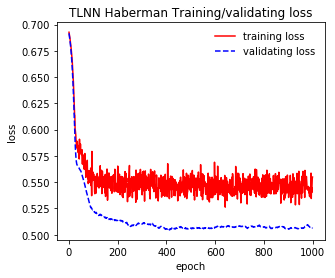

In [9]:
# Summarize history for loss.

plt.ion()

plt.figure('Figure Haberman loss', figsize = (4.8, 4.0))
plt.plot(history.history['loss'], "r-")
plt.plot(history.history['val_loss'], "b--")
plt.title('TLNN Haberman Training/validating loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validating loss'], loc = "best", frameon = False)

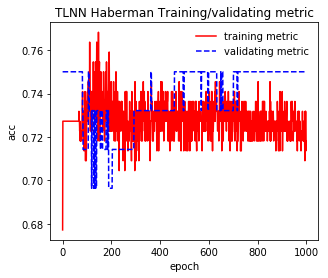

In [10]:
# Summarize history for metric.

plt.figure('Figure Haberman metric', figsize = (4.8, 4.0))
plt.plot(history.history['acc'], "r-")
plt.plot(history.history['val_acc'], "b--")
plt.title('TLNN Haberman Training/validating metric')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['training metric', 'validating metric'], loc = "best", frameon = False)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_100 (Dense)               (None, 3)            6           input_28[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 3)            0           dense_100[0][0]                  
__________________________________________________________________________________________________
dense_101 (Dense)               (None, 1)            4           dropout_37[0][0]                 
__________________________________________________________________________________________________
input_29 (